# IMPORTS

In [1]:
import os
import math
import time
import torch
import random
import warnings
import numpy as np
import pandas as pd
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score, classification_report
from torch.multiprocessing import Manager
from torch.utils.data import DataLoader, Dataset
from accelerate import Accelerator, notebook_launcher
from transformers import BertTokenizer, BertModel, BertPreTrainedModel, BertConfig, BertForSequenceClassification

# SETUP

In [2]:
warnings.filterwarnings('ignore')

In [3]:
if os.path.exists('/kaggle/working/results') == False:
    os.mkdir('/kaggle/working/results')

if os.path.exists('/kaggle/working/acquired_data') == False:
    os.mkdir('/kaggle/working/acquired_data')

In [4]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic=True
    torch.backends.cudnn.benchmark=False

set_seed(42)

# GLOBAL VARIABLES

In [5]:
manager = Manager()

# Shared resources
accuracies = manager.list()
f1_micros = manager.list()
f1_macros = manager.list()
data_used = manager.list()
sampling_dur = manager.list()
new_samples = manager.list()

# Non shared resources
filename = 'netifier-random-kfold'
epochs = 10
batch_size = 32
sequence_length = 96
min_increment = 200

# LOAD AND PREPROCESS DATA

In [6]:
train_data = pd.read_csv('/kaggle/input/netifier-3/processed_train.csv', encoding='latin-1')
val_data = pd.read_csv('/kaggle/input/netifier-3/processed_test.csv', encoding='latin-1')

data = pd.concat([train_data, val_data], ignore_index=True)
data.shape

(7773, 7)

In [7]:
data.head()

,original_text,source,pornografi,sara,radikalisme,pencemaran_nama_baik,processed_text
0,[QUOTE=jessepinkman16;5a50ac34d89b093f368b456e...,kaskus,0,0,0,1,jabar memang provinsi barokah boleh juga dan n...
1,"@verosvante kita2 aja nitizen yang pada kepo,t...",instagram,0,0,0,0,kita saja nitizen yang pada penasaran toh kelu...
2,"""#SidangAhok smg sipenista agama n ateknya mat...",twitter,0,1,1,1,sidangahok semoga sipenista agama dan ateknya ...
3,@bolususulembang.jkt barusan baca undang2 ini....,instagram,0,0,0,0,jakarta barusan baca undang ini tetap dibedaka...
4,bikin anak mulu lu nof \nkaga mikir apa kasian...,kaskus,0,0,0,0,buat anak melulu kamu nof nkaga mikir apa kasi...


# BUILD DATASET & DATALOADERS

In [8]:
class NetifierDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=96):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        labels = self.labels[idx]
        # print(labels)
        encoding = self.tokenizer(text, truncation=True, padding='max_length', max_length=self.max_length, return_tensors='pt')
        item = {key: val.squeeze() for key, val in encoding.items()}
        item['labels'] = torch.tensor(labels, dtype=torch.float)
        # print(item['labels'])
        return item

# Initialize BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p1')

tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

In [9]:
def get_dataloaders(X_train, y_train, X_val, y_val, sequence_length=96, num_workers=4):
    train_dataset = NetifierDataset(X_train, y_train, tokenizer, max_length=sequence_length)
    val_dataset = NetifierDataset(X_val, y_val, tokenizer, max_length=sequence_length)
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=num_workers
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=num_workers
    )

    return train_loader, val_loader

# TRAIN THE MODEL

In [10]:
def compute_metrics(p):
    preds = torch.tensor(p.predictions) # Sigmoid and threshold for multi-label
    labels = torch.tensor(p.label_ids)

    # Hamming accuracy: proportion of correctly predicted labels over total labels
    accuracy = (preds == labels).float().mean().item()

    # Standard multi-label precision, recall, and F1 metrics
    precision, recall, f1_micro, _ = precision_recall_fscore_support(labels, preds, average='micro', zero_division=0)
    _, _, f1_macro, _ = precision_recall_fscore_support(labels, preds, average='macro', zero_division=0)

    report = classification_report(
        labels, 
        preds, 
        target_names=['pornografi', 'sara', 'radikalisme', 'pencemaran_nama_baik'],
        zero_division=0
    ) 

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_micro': f1_micro,
        'f1_macro': f1_macro,
        'report': report
    }

In [11]:
def train_model(current_train_size, train_indices, metrics, trials, seed, X_train_fold, y_train_fold, X_val_fold, y_val_fold, label_columns):
    accelerator = Accelerator(mixed_precision='fp16')  # Initialize the accelerator
    device = accelerator.device

    accelerator.print(f"Fold {trials + 1} - Training with {current_train_size} samples...")

    with accelerator.main_process_first():
        model = BertForSequenceClassification.from_pretrained(
            'indobenchmark/indobert-base-p1',
            num_labels=len(label_columns),
            problem_type="multi_label_classification"
        )

    # Freeze the first few layers of the encoder
    for name, param in model.named_parameters():
        if "encoder.layer" in name:
            layer_num = name.split(".")[3]
            try:
                if int(layer_num) < 6:
                    param.requires_grad = False
            except ValueError:
                continue

    # Define DataLoaders using the fold's data
    current_X_train = [X_train_fold[i] for i in train_indices]
    current_y_train = [y_train_fold[i] for i in train_indices]
    train_loader, val_loader = get_dataloaders(current_X_train, current_y_train, X_val_fold, y_val_fold)

    # Define optimizer and loss function
    optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)
    loss_fn = torch.nn.BCEWithLogitsLoss()

    # Prepare everything with Accelerator
    model, optimizer, train_loader, val_loader = accelerator.prepare(
        model, optimizer, train_loader, val_loader
    )

    best_result = None
    start_time = time.time()

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0

        for batch in train_loader:
            inputs = {key: val for key, val in batch.items() if key != 'labels'}
            labels = batch['labels']

            optimizer.zero_grad()
            outputs = model(**inputs)
            loss = loss_fn(outputs.logits, labels)
            accelerator.backward(loss)
            optimizer.step()

            epoch_loss += loss.item()

        # Evaluation
        model.eval()
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for batch in val_loader:
                inputs = {key: val for key, val in batch.items() if key != 'labels'}
                labels = batch['labels']
                
                outputs = model(**inputs)
                preds = torch.sigmoid(outputs.logits).round()

                # Gather predictions and labels from all devices
                all_preds.append(accelerator.gather(preds))
                all_labels.append(accelerator.gather(labels))

        all_preds = torch.cat(all_preds).cpu().numpy()
        all_labels = torch.cat(all_labels).cpu().numpy()

        result = compute_metrics(type('EvalOutput', (object,), {'predictions': all_preds, 'label_ids': all_labels}))

        if best_result is None or result['f1_micro'] >= best_result['f1_micro']:
            accelerator.wait_for_everyone()
            unwrapped_model = accelerator.unwrap_model(model)
            unwrapped_model.save_pretrained(
                f'{filename}-fold-{trials + 1}-model',
                is_main_process=accelerator.is_main_process,
                save_function=accelerator.save,
            )
            best_result = result
        
        accelerator.print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {round(epoch_loss / len(train_loader), 4)}, Accuracy: {round(result['accuracy'], 4)}, F1 Micro: {round(result['f1_micro'], 4)}, F1 Macro: {round(result['f1_macro'], 4)}")

    end_time = time.time()
    duration = end_time - start_time
    
    accelerator.print(f"Best result for {current_train_size} samples: F1 Micro: {round(best_result['f1_micro'], 4)}")
    accelerator.print(best_result['report'])
    
    # Update the shared lists
    if accelerator.is_local_main_process:
        metrics[0].append(current_train_size)
        metrics[1].append(best_result['accuracy'])
        metrics[2].append(best_result['f1_micro'])
        metrics[3].append(best_result['f1_macro'])

# PLOT THE RESULTS

In [12]:
import matplotlib.pyplot as plt

def plot_result(data_used, accuracies, f1_micros, f1_macros):
    fig, axs = plt.subplots(1, 3, figsize=(21, 5))
    data_used = [round(data / total_data * 100, 1) for data in data_used]

    # Plot for Accuracy
    axs[0].plot(data_used, accuracies, label="Accuracy", color="blue")
    axs[0].set_xlabel("Percentage of data used")
    axs[0].set_title("Accuracy")
    axs[0].set_xticks(data_used)

    # Plot for F1 Micro
    axs[1].plot(data_used, f1_micros, label="F1 Micro", color="orange")
    axs[1].set_xlabel("Percentage of data used")
    axs[1].set_title("F1 Micro")
    axs[1].set_xticks(data_used)

    # Plot for F1 Macro
    axs[2].plot(data_used, f1_macros, label="F1 Macro", color="green")
    axs[2].set_xlabel("Percentage of data used")
    axs[2].set_title("F1 Macro")
    axs[2].set_xticks(data_used)

    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()

# QUERY STRATEGY

In [13]:
def random_sampling(current_train_size, X_pool, train_indices, remaining_indices, sampling_dur, new_samples, trials, X_train_fold, y_train_fold, n_samples=min_increment):
    start_time = time.time()
    
    nearest_cp = 0
    arrived_at_cp = False
    for cp in checkpoints:
        if cp > current_train_size:
            nearest_cp = cp
            break

    num_of_candidates = math.ceil(0.1 * len(remaining_indices))

    if num_of_candidates <= n_samples and n_samples < nearest_cp - current_train_size:
        num_of_candidates = n_samples
    elif num_of_candidates > n_samples and num_of_candidates < nearest_cp - current_train_size:
        num_of_candidates = max(n_samples, num_of_candidates)
    else:
        num_of_candidates = nearest_cp - current_train_size
        arrived_at_cp = True

    if len(remaining_indices) < n_samples:
        random_indices = range(len(X_pool))
    else:
        random_indices = random.sample(range(len(X_pool)), num_of_candidates)

    if arrived_at_cp:
        temp = train_indices.copy()
        temp.extend([remaining_indices[i] for i in random_indices])
            
        # Save acquired data up to checkpoint
        acquired_data = pd.DataFrame({
            'processed_text': [X_train_fold[i] for i in temp],
            'pornografi': [y_train_fold[i][0] for i in temp],
            'sara': [y_train_fold[i][1] for i in temp],
            'radikalisme': [y_train_fold[i][2] for i in temp],
            'pencemaran_nama_baik': [y_train_fold[i][3] for i in temp],
        })

        acquired_data.to_csv(f'acquired_data/{filename}-fold-{trials+1}-data-{nearest_cp}.csv', index=False)

    end_time = time.time() 
    duration = end_time - start_time

    sampling_dur.append(duration)
    for i in random_indices:
        new_samples.append(remaining_indices[i])
        
    print("Nearest checkpoint:", nearest_cp)
    print("Acquired samples:", len(random_indices))
    print(f"Sampling duration: {duration} seconds")

# MAIN LOOP

In [14]:
from sklearn.model_selection import KFold

N_SPLITS = 5
RANDOM_SEED = 42

# Prepare data for K-Fold
label_columns = data.columns[2:6]
X = data['processed_text'].values
y = data[label_columns].values
kf = KFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_SEED)

# Each element in these lists will be a list of metrics for one fold's learning curve
all_fold_accuracies = []
all_fold_f1_micros = []
all_fold_f1_macros = []
all_fold_data_used = []

for fold, (train_index, val_index) in enumerate(kf.split(X)):
    print("===============================================")
    print(f"STARTING FOLD {fold + 1}/{N_SPLITS}")
    print("===============================================")

    X_train_fold, X_val_fold = X[train_index], X[val_index]
    y_train_fold, y_val_fold = y[train_index], y[val_index]

    # Shared resources for this fold's processes
    accuracies = manager.list()
    f1_micros = manager.list()
    f1_macros = manager.list()
    data_used = manager.list()
    sampling_dur = manager.list()
    
    # Set seed for reproducibility within the fold
    set_seed(RANDOM_SEED + fold)
    
    # Define the initial labeled pool from the current fold's training data
    total_train_fold_size = len(X_train_fold) + len(X_val_fold)
    initial_train_size = int(0.05 * total_train_fold_size)
    
    train_indices = np.random.choice(range(len(X_train_fold)), initial_train_size, replace=False).tolist()
    remaining_indices = list(set(range(len(X_train_fold))) - set(train_indices))
    current_train_size = initial_train_size

    # Adjust checkpoints based on the current fold's training size
    checkpoints = [
        int(0.5 * total_train_fold_size), 
        int(0.6 * total_train_fold_size),
        int(0.7 * total_train_fold_size),
        len(X_train_fold)
    ]
    
    fold_start_time = time.time()
    
    while current_train_size < total_train_fold_size:
        # 1. Train the model on the current labeled set
        train_args = (
            current_train_size, train_indices, (data_used, accuracies, f1_micros, f1_macros),
            fold, RANDOM_SEED + fold, X_train_fold, y_train_fold, X_val_fold, y_val_fold, label_columns
        )
        notebook_launcher(train_model, train_args, num_processes=2)
        
        # Stop if we've reached the last checkpoint
        if current_train_size >= checkpoints[-1]:
            break
        
        # 3. Perform query strategy to select new samples
        new_samples_shared = manager.list()
        X_pool = [X_train_fold[i] for i in remaining_indices]
        random_sampling(current_train_size, X_pool, train_indices, remaining_indices, sampling_dur, new_samples_shared, fold, X_train_fold, y_train_fold)
        
        # 4. Update the pools
        newly_acquired_indices = list(new_samples_shared)
        train_indices.extend(newly_acquired_indices)
        remaining_indices = list(set(remaining_indices) - set(newly_acquired_indices))
    
        current_train_size = len(train_indices)
        print(f"\nFold {fold + 1} - New train size: {current_train_size}\n")
    
    fold_end_time = time.time()
    print(f"\nFOLD {fold + 1} COMPLETED in {fold_end_time - fold_start_time:.2f} seconds")
    
    # Store the results for this fold
    all_fold_data_used.append(list(data_used))
    all_fold_accuracies.append(list(accuracies))
    all_fold_f1_micros.append(list(f1_micros))
    all_fold_f1_macros.append(list(f1_macros))

STARTING FOLD 1/5
Launching training on 2 GPUs.
Fold 1 - Training with 388 samples...


pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.5963, Accuracy: 0.7902, F1 Micro: 0.0, F1 Macro: 0.0
Epoch 2/10, Train Loss: 0.5233, Accuracy: 0.7902, F1 Micro: 0.0, F1 Macro: 0.0
Epoch 3/10, Train Loss: 0.4851, Accuracy: 0.8166, F1 Micro: 0.2367, F1 Macro: 0.1613
Epoch 4/10, Train Loss: 0.4274, Accuracy: 0.8252, F1 Micro: 0.3327, F1 Macro: 0.227
Epoch 5/10, Train Loss: 0.3978, Accuracy: 0.8386, F1 Micro: 0.4661, F1 Macro: 0.3619
Epoch 6/10, Train Loss: 0.349, Accuracy: 0.8506, F1 Micro: 0.5631, F1 Macro: 0.5253
Epoch 7/10, Train Loss: 0.3106, Accuracy: 0.862, F1 Micro: 0.652, F1 Macro: 0.6434
Epoch 8/10, Train Loss: 0.2486, Accuracy: 0.8617, F1 Micro: 0.6641, F1 Macro: 0.6497
Epoch 9/10, Train Loss: 0.2302, Accuracy: 0.8678, F1 Micro: 0.6874, F1 Macro: 0.684
Epoch 10/10, Train Loss: 0.1741, Accuracy: 0.8681, F1 Micro: 0.6544, F1 Macro: 0.6387
Best result for 388 samples: F1 Micro: 0.6874
                      precision    recall  f1-score   support

          pornografi       0.91      0.79      0.85      

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.5462, Accuracy: 0.8044, F1 Micro: 0.133, F1 Macro: 0.1021
Epoch 2/10, Train Loss: 0.4524, Accuracy: 0.8366, F1 Micro: 0.4137, F1 Macro: 0.3359
Epoch 3/10, Train Loss: 0.3485, Accuracy: 0.8619, F1 Micro: 0.6078, F1 Macro: 0.5889
Epoch 4/10, Train Loss: 0.2735, Accuracy: 0.8761, F1 Micro: 0.6993, F1 Macro: 0.6935
Epoch 5/10, Train Loss: 0.2214, Accuracy: 0.8769, F1 Micro: 0.6919, F1 Macro: 0.6784
Epoch 6/10, Train Loss: 0.1797, Accuracy: 0.8798, F1 Micro: 0.7205, F1 Macro: 0.7162
Epoch 7/10, Train Loss: 0.1599, Accuracy: 0.8752, F1 Micro: 0.7192, F1 Macro: 0.7189
Epoch 8/10, Train Loss: 0.1224, Accuracy: 0.8836, F1 Micro: 0.6876, F1 Macro: 0.6761
Epoch 9/10, Train Loss: 0.0917, Accuracy: 0.882, F1 Micro: 0.7148, F1 Macro: 0.713
Epoch 10/10, Train Loss: 0.0726, Accuracy: 0.882, F1 Micro: 0.7008, F1 Macro: 0.6912
Best result for 971 samples: F1 Micro: 0.7205
                      precision    recall  f1-score   support

          pornografi       0.88      0.85   

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.5106, Accuracy: 0.8258, F1 Micro: 0.307, F1 Macro: 0.21
Epoch 2/10, Train Loss: 0.3856, Accuracy: 0.8584, F1 Micro: 0.6614, F1 Macro: 0.6551
Epoch 3/10, Train Loss: 0.3087, Accuracy: 0.8716, F1 Micro: 0.6558, F1 Macro: 0.651
Epoch 4/10, Train Loss: 0.2469, Accuracy: 0.8778, F1 Micro: 0.657, F1 Macro: 0.6367
Epoch 5/10, Train Loss: 0.2018, Accuracy: 0.8833, F1 Micro: 0.7011, F1 Macro: 0.6931
Epoch 6/10, Train Loss: 0.1635, Accuracy: 0.8848, F1 Micro: 0.7136, F1 Macro: 0.7086
Epoch 7/10, Train Loss: 0.131, Accuracy: 0.8831, F1 Micro: 0.6969, F1 Macro: 0.681
Epoch 8/10, Train Loss: 0.0958, Accuracy: 0.8825, F1 Micro: 0.7162, F1 Macro: 0.7125
Epoch 9/10, Train Loss: 0.0747, Accuracy: 0.8867, F1 Micro: 0.7106, F1 Macro: 0.7011
Epoch 10/10, Train Loss: 0.0505, Accuracy: 0.8809, F1 Micro: 0.6971, F1 Macro: 0.6856
Best result for 1496 samples: F1 Micro: 0.7162
                      precision    recall  f1-score   support

          pornografi       0.90      0.85     

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4734, Accuracy: 0.832, F1 Micro: 0.3597, F1 Macro: 0.2561
Epoch 2/10, Train Loss: 0.3362, Accuracy: 0.8711, F1 Micro: 0.6526, F1 Macro: 0.6432
Epoch 3/10, Train Loss: 0.2601, Accuracy: 0.8794, F1 Micro: 0.7235, F1 Macro: 0.7179
Epoch 4/10, Train Loss: 0.2123, Accuracy: 0.8898, F1 Micro: 0.7197, F1 Macro: 0.7117
Epoch 5/10, Train Loss: 0.1654, Accuracy: 0.8891, F1 Micro: 0.7061, F1 Macro: 0.6988
Epoch 6/10, Train Loss: 0.1363, Accuracy: 0.89, F1 Micro: 0.7211, F1 Macro: 0.7147
Epoch 7/10, Train Loss: 0.0884, Accuracy: 0.8881, F1 Micro: 0.7244, F1 Macro: 0.7173
Epoch 8/10, Train Loss: 0.0708, Accuracy: 0.8905, F1 Micro: 0.7026, F1 Macro: 0.6907
Epoch 9/10, Train Loss: 0.06, Accuracy: 0.8891, F1 Micro: 0.7337, F1 Macro: 0.7278
Epoch 10/10, Train Loss: 0.0447, Accuracy: 0.8872, F1 Micro: 0.7271, F1 Macro: 0.7238
Best result for 1969 samples: F1 Micro: 0.7337
                      precision    recall  f1-score   support

          pornografi       0.90      0.85   

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4706, Accuracy: 0.8363, F1 Micro: 0.4712, F1 Macro: 0.4161
Epoch 2/10, Train Loss: 0.3103, Accuracy: 0.8809, F1 Micro: 0.6859, F1 Macro: 0.6729
Epoch 3/10, Train Loss: 0.2406, Accuracy: 0.887, F1 Micro: 0.693, F1 Macro: 0.6728
Epoch 4/10, Train Loss: 0.2044, Accuracy: 0.8902, F1 Micro: 0.7368, F1 Macro: 0.7298
Epoch 5/10, Train Loss: 0.1459, Accuracy: 0.887, F1 Micro: 0.7347, F1 Macro: 0.7305
Epoch 6/10, Train Loss: 0.1069, Accuracy: 0.8864, F1 Micro: 0.7218, F1 Macro: 0.7153
Epoch 7/10, Train Loss: 0.0888, Accuracy: 0.8902, F1 Micro: 0.7233, F1 Macro: 0.7154
Epoch 8/10, Train Loss: 0.0621, Accuracy: 0.8883, F1 Micro: 0.7341, F1 Macro: 0.7299
Epoch 9/10, Train Loss: 0.0488, Accuracy: 0.8905, F1 Micro: 0.7297, F1 Macro: 0.7248
Epoch 10/10, Train Loss: 0.0404, Accuracy: 0.8944, F1 Micro: 0.7313, F1 Macro: 0.7276
Best result for 2394 samples: F1 Micro: 0.7368
                      precision    recall  f1-score   support

          pornografi       0.93      0.82 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4449, Accuracy: 0.8495, F1 Micro: 0.5337, F1 Macro: 0.4861
Epoch 2/10, Train Loss: 0.2865, Accuracy: 0.8836, F1 Micro: 0.7033, F1 Macro: 0.687
Epoch 3/10, Train Loss: 0.2327, Accuracy: 0.8942, F1 Micro: 0.7369, F1 Macro: 0.7311
Epoch 4/10, Train Loss: 0.1839, Accuracy: 0.8881, F1 Micro: 0.7354, F1 Macro: 0.7321
Epoch 5/10, Train Loss: 0.146, Accuracy: 0.8742, F1 Micro: 0.7285, F1 Macro: 0.7279
Epoch 6/10, Train Loss: 0.105, Accuracy: 0.8919, F1 Micro: 0.7316, F1 Macro: 0.7267
Epoch 7/10, Train Loss: 0.0846, Accuracy: 0.8923, F1 Micro: 0.7128, F1 Macro: 0.7003
Epoch 8/10, Train Loss: 0.0614, Accuracy: 0.8847, F1 Micro: 0.7429, F1 Macro: 0.7445
Epoch 9/10, Train Loss: 0.0473, Accuracy: 0.8894, F1 Micro: 0.736, F1 Macro: 0.7322
Epoch 10/10, Train Loss: 0.0372, Accuracy: 0.8936, F1 Micro: 0.7439, F1 Macro: 0.7417
Best result for 2777 samples: F1 Micro: 0.7439
                      precision    recall  f1-score   support

          pornografi       0.92      0.85  

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4362, Accuracy: 0.857, F1 Micro: 0.5869, F1 Macro: 0.5658
Epoch 2/10, Train Loss: 0.288, Accuracy: 0.8878, F1 Micro: 0.706, F1 Macro: 0.6953
Epoch 3/10, Train Loss: 0.2279, Accuracy: 0.8945, F1 Micro: 0.7251, F1 Macro: 0.7154
Epoch 4/10, Train Loss: 0.185, Accuracy: 0.8927, F1 Micro: 0.7038, F1 Macro: 0.6886
Epoch 5/10, Train Loss: 0.1511, Accuracy: 0.8934, F1 Micro: 0.7212, F1 Macro: 0.7118
Epoch 6/10, Train Loss: 0.1093, Accuracy: 0.8936, F1 Micro: 0.7499, F1 Macro: 0.7513
Epoch 7/10, Train Loss: 0.0797, Accuracy: 0.8891, F1 Micro: 0.7374, F1 Macro: 0.7369
Epoch 8/10, Train Loss: 0.0648, Accuracy: 0.8947, F1 Micro: 0.742, F1 Macro: 0.7364
Epoch 9/10, Train Loss: 0.05, Accuracy: 0.8927, F1 Micro: 0.7434, F1 Macro: 0.7383
Epoch 10/10, Train Loss: 0.0366, Accuracy: 0.8942, F1 Micro: 0.7419, F1 Macro: 0.7381
Best result for 3122 samples: F1 Micro: 0.7499
                      precision    recall  f1-score   support

          pornografi       0.93      0.84     

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4345, Accuracy: 0.865, F1 Micro: 0.6201, F1 Macro: 0.6
Epoch 2/10, Train Loss: 0.2712, Accuracy: 0.892, F1 Micro: 0.7194, F1 Macro: 0.7143
Epoch 3/10, Train Loss: 0.2142, Accuracy: 0.8947, F1 Micro: 0.7373, F1 Macro: 0.7278
Epoch 4/10, Train Loss: 0.1814, Accuracy: 0.8958, F1 Micro: 0.7482, F1 Macro: 0.7439
Epoch 5/10, Train Loss: 0.1426, Accuracy: 0.8945, F1 Micro: 0.7432, F1 Macro: 0.7374
Epoch 6/10, Train Loss: 0.1029, Accuracy: 0.8961, F1 Micro: 0.7614, F1 Macro: 0.7584
Epoch 7/10, Train Loss: 0.0802, Accuracy: 0.8944, F1 Micro: 0.7544, F1 Macro: 0.7553
Epoch 8/10, Train Loss: 0.0574, Accuracy: 0.8961, F1 Micro: 0.7451, F1 Macro: 0.7421
Epoch 9/10, Train Loss: 0.0471, Accuracy: 0.8978, F1 Micro: 0.7492, F1 Macro: 0.7468
Epoch 10/10, Train Loss: 0.0344, Accuracy: 0.895, F1 Micro: 0.715, F1 Macro: 0.7022
Best result for 3432 samples: F1 Micro: 0.7614
                      precision    recall  f1-score   support

          pornografi       0.91      0.88     

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4112, Accuracy: 0.8684, F1 Micro: 0.6333, F1 Macro: 0.6106
Epoch 2/10, Train Loss: 0.2598, Accuracy: 0.8917, F1 Micro: 0.7135, F1 Macro: 0.6965
Epoch 3/10, Train Loss: 0.2219, Accuracy: 0.895, F1 Micro: 0.7429, F1 Macro: 0.7394
Epoch 4/10, Train Loss: 0.1822, Accuracy: 0.8967, F1 Micro: 0.7495, F1 Macro: 0.7477
Epoch 5/10, Train Loss: 0.1358, Accuracy: 0.8973, F1 Micro: 0.7354, F1 Macro: 0.716
Epoch 6/10, Train Loss: 0.1118, Accuracy: 0.8973, F1 Micro: 0.7333, F1 Macro: 0.7203
Epoch 7/10, Train Loss: 0.0777, Accuracy: 0.8977, F1 Micro: 0.7497, F1 Macro: 0.7463
Epoch 8/10, Train Loss: 0.0612, Accuracy: 0.8995, F1 Micro: 0.7605, F1 Macro: 0.7575
Epoch 9/10, Train Loss: 0.046, Accuracy: 0.9, F1 Micro: 0.7458, F1 Macro: 0.739
Epoch 10/10, Train Loss: 0.0344, Accuracy: 0.8981, F1 Micro: 0.7519, F1 Macro: 0.7517
Best result for 3711 samples: F1 Micro: 0.7605
                      precision    recall  f1-score   support

          pornografi       0.92      0.87     

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4179, Accuracy: 0.8717, F1 Micro: 0.6772, F1 Macro: 0.6737
Epoch 2/10, Train Loss: 0.2669, Accuracy: 0.8905, F1 Micro: 0.7184, F1 Macro: 0.7129
Epoch 3/10, Train Loss: 0.2111, Accuracy: 0.8991, F1 Micro: 0.7368, F1 Macro: 0.726
Epoch 4/10, Train Loss: 0.1767, Accuracy: 0.8983, F1 Micro: 0.7541, F1 Macro: 0.7471
Epoch 5/10, Train Loss: 0.1353, Accuracy: 0.9002, F1 Micro: 0.7545, F1 Macro: 0.7519
Epoch 6/10, Train Loss: 0.1001, Accuracy: 0.8931, F1 Micro: 0.754, F1 Macro: 0.7526
Epoch 7/10, Train Loss: 0.0733, Accuracy: 0.8994, F1 Micro: 0.7584, F1 Macro: 0.7566
Epoch 8/10, Train Loss: 0.0569, Accuracy: 0.9009, F1 Micro: 0.7608, F1 Macro: 0.76
Epoch 9/10, Train Loss: 0.0396, Accuracy: 0.8963, F1 Micro: 0.7546, F1 Macro: 0.7538
Epoch 10/10, Train Loss: 0.0324, Accuracy: 0.8945, F1 Micro: 0.7575, F1 Macro: 0.7568
Best result for 3886 samples: F1 Micro: 0.7608
                      precision    recall  f1-score   support

          pornografi       0.94      0.85  

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4149, Accuracy: 0.8745, F1 Micro: 0.6908, F1 Macro: 0.6874
Epoch 2/10, Train Loss: 0.255, Accuracy: 0.8966, F1 Micro: 0.7402, F1 Macro: 0.7316
Epoch 3/10, Train Loss: 0.2183, Accuracy: 0.9013, F1 Micro: 0.7474, F1 Macro: 0.7352
Epoch 4/10, Train Loss: 0.1792, Accuracy: 0.9013, F1 Micro: 0.7406, F1 Macro: 0.7278
Epoch 5/10, Train Loss: 0.1369, Accuracy: 0.8988, F1 Micro: 0.7289, F1 Macro: 0.7101
Epoch 6/10, Train Loss: 0.0967, Accuracy: 0.9056, F1 Micro: 0.7622, F1 Macro: 0.7542
Epoch 7/10, Train Loss: 0.0732, Accuracy: 0.9022, F1 Micro: 0.7609, F1 Macro: 0.7525
Epoch 8/10, Train Loss: 0.0587, Accuracy: 0.8997, F1 Micro: 0.7478, F1 Macro: 0.7333
Epoch 9/10, Train Loss: 0.0442, Accuracy: 0.9009, F1 Micro: 0.7609, F1 Macro: 0.7553
Epoch 10/10, Train Loss: 0.0345, Accuracy: 0.8969, F1 Micro: 0.7622, F1 Macro: 0.7616
Best result for 4120 samples: F1 Micro: 0.7622
                      precision    recall  f1-score   support

          pornografi       0.93      0.8

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4097, Accuracy: 0.8719, F1 Micro: 0.6875, F1 Macro: 0.6752
Epoch 2/10, Train Loss: 0.2605, Accuracy: 0.8917, F1 Micro: 0.739, F1 Macro: 0.7291
Epoch 3/10, Train Loss: 0.2124, Accuracy: 0.8992, F1 Micro: 0.7491, F1 Macro: 0.7417
Epoch 4/10, Train Loss: 0.1667, Accuracy: 0.9005, F1 Micro: 0.753, F1 Macro: 0.7453
Epoch 5/10, Train Loss: 0.1319, Accuracy: 0.9009, F1 Micro: 0.7537, F1 Macro: 0.7505
Epoch 6/10, Train Loss: 0.0993, Accuracy: 0.8991, F1 Micro: 0.7711, F1 Macro: 0.7718
Epoch 7/10, Train Loss: 0.0719, Accuracy: 0.9013, F1 Micro: 0.7537, F1 Macro: 0.7475
Epoch 8/10, Train Loss: 0.055, Accuracy: 0.9023, F1 Micro: 0.7563, F1 Macro: 0.7505
Epoch 9/10, Train Loss: 0.0407, Accuracy: 0.9039, F1 Micro: 0.7585, F1 Macro: 0.7545
Epoch 10/10, Train Loss: 0.0336, Accuracy: 0.8994, F1 Micro: 0.7677, F1 Macro: 0.7681
Best result for 4330 samples: F1 Micro: 0.7711
                      precision    recall  f1-score   support

          pornografi       0.93      0.88 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4033, Accuracy: 0.8773, F1 Micro: 0.6879, F1 Macro: 0.6813
Epoch 2/10, Train Loss: 0.2547, Accuracy: 0.8959, F1 Micro: 0.7388, F1 Macro: 0.7178
Epoch 3/10, Train Loss: 0.2061, Accuracy: 0.8997, F1 Micro: 0.7574, F1 Macro: 0.7541
Epoch 4/10, Train Loss: 0.1662, Accuracy: 0.902, F1 Micro: 0.7692, F1 Macro: 0.7675
Epoch 5/10, Train Loss: 0.135, Accuracy: 0.8967, F1 Micro: 0.7627, F1 Macro: 0.7614
Epoch 6/10, Train Loss: 0.1034, Accuracy: 0.9031, F1 Micro: 0.7506, F1 Macro: 0.7451
Epoch 7/10, Train Loss: 0.0688, Accuracy: 0.9027, F1 Micro: 0.769, F1 Macro: 0.7652
Epoch 8/10, Train Loss: 0.0579, Accuracy: 0.8992, F1 Micro: 0.7567, F1 Macro: 0.7508
Epoch 9/10, Train Loss: 0.0433, Accuracy: 0.9006, F1 Micro: 0.7634, F1 Macro: 0.7604
Epoch 10/10, Train Loss: 0.0287, Accuracy: 0.8973, F1 Micro: 0.7632, F1 Macro: 0.7624
Best result for 4530 samples: F1 Micro: 0.7692
                      precision    recall  f1-score   support

          pornografi       0.94      0.87 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3939, Accuracy: 0.8756, F1 Micro: 0.6563, F1 Macro: 0.6431
Epoch 2/10, Train Loss: 0.2518, Accuracy: 0.892, F1 Micro: 0.7146, F1 Macro: 0.6785
Epoch 3/10, Train Loss: 0.2045, Accuracy: 0.9061, F1 Micro: 0.768, F1 Macro: 0.7618
Epoch 4/10, Train Loss: 0.1709, Accuracy: 0.9023, F1 Micro: 0.7614, F1 Macro: 0.7544
Epoch 5/10, Train Loss: 0.1322, Accuracy: 0.9056, F1 Micro: 0.771, F1 Macro: 0.7677
Epoch 6/10, Train Loss: 0.0998, Accuracy: 0.9044, F1 Micro: 0.7699, F1 Macro: 0.7684
Epoch 7/10, Train Loss: 0.0707, Accuracy: 0.9058, F1 Micro: 0.7666, F1 Macro: 0.7604
Epoch 8/10, Train Loss: 0.0566, Accuracy: 0.9025, F1 Micro: 0.768, F1 Macro: 0.7656
Epoch 9/10, Train Loss: 0.0413, Accuracy: 0.9059, F1 Micro: 0.769, F1 Macro: 0.7651
Epoch 10/10, Train Loss: 0.0307, Accuracy: 0.9052, F1 Micro: 0.7652, F1 Macro: 0.7632
Best result for 4663 samples: F1 Micro: 0.771
                      precision    recall  f1-score   support

          pornografi       0.94      0.88    

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3948, Accuracy: 0.8763, F1 Micro: 0.7197, F1 Macro: 0.7146
Epoch 2/10, Train Loss: 0.2421, Accuracy: 0.8925, F1 Micro: 0.7562, F1 Macro: 0.7557
Epoch 3/10, Train Loss: 0.2017, Accuracy: 0.903, F1 Micro: 0.7684, F1 Macro: 0.7634
Epoch 4/10, Train Loss: 0.1631, Accuracy: 0.9023, F1 Micro: 0.7481, F1 Macro: 0.7405
Epoch 5/10, Train Loss: 0.1296, Accuracy: 0.9028, F1 Micro: 0.7703, F1 Macro: 0.7662
Epoch 6/10, Train Loss: 0.0966, Accuracy: 0.9031, F1 Micro: 0.7717, F1 Macro: 0.7712
Epoch 7/10, Train Loss: 0.0674, Accuracy: 0.9033, F1 Micro: 0.7732, F1 Macro: 0.7714
Epoch 8/10, Train Loss: 0.0489, Accuracy: 0.9002, F1 Micro: 0.7639, F1 Macro: 0.7652
Epoch 9/10, Train Loss: 0.039, Accuracy: 0.9028, F1 Micro: 0.7595, F1 Macro: 0.7537
Epoch 10/10, Train Loss: 0.0335, Accuracy: 0.9009, F1 Micro: 0.7673, F1 Macro: 0.7648
Best result for 4863 samples: F1 Micro: 0.7732
                      precision    recall  f1-score   support

          pornografi       0.93      0.89

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.387, Accuracy: 0.8842, F1 Micro: 0.703, F1 Macro: 0.6899
Epoch 2/10, Train Loss: 0.2461, Accuracy: 0.8964, F1 Micro: 0.7461, F1 Macro: 0.7423
Epoch 3/10, Train Loss: 0.1967, Accuracy: 0.903, F1 Micro: 0.7539, F1 Macro: 0.7465
Epoch 4/10, Train Loss: 0.1632, Accuracy: 0.9011, F1 Micro: 0.7716, F1 Macro: 0.7688
Epoch 5/10, Train Loss: 0.1276, Accuracy: 0.9044, F1 Micro: 0.7703, F1 Macro: 0.7659
Epoch 6/10, Train Loss: 0.0955, Accuracy: 0.8989, F1 Micro: 0.7626, F1 Macro: 0.7609
Epoch 7/10, Train Loss: 0.0704, Accuracy: 0.8995, F1 Micro: 0.7711, F1 Macro: 0.773
Epoch 8/10, Train Loss: 0.0549, Accuracy: 0.9038, F1 Micro: 0.7691, F1 Macro: 0.7666
Epoch 9/10, Train Loss: 0.0402, Accuracy: 0.9061, F1 Micro: 0.7714, F1 Macro: 0.7659
Epoch 10/10, Train Loss: 0.0324, Accuracy: 0.9025, F1 Micro: 0.7638, F1 Macro: 0.7624
Best result for 5063 samples: F1 Micro: 0.7716
                      precision    recall  f1-score   support

          pornografi       0.95      0.87  

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3868, Accuracy: 0.8827, F1 Micro: 0.7165, F1 Macro: 0.7044
Epoch 2/10, Train Loss: 0.2495, Accuracy: 0.898, F1 Micro: 0.741, F1 Macro: 0.7323
Epoch 3/10, Train Loss: 0.1974, Accuracy: 0.8959, F1 Micro: 0.765, F1 Macro: 0.7635
Epoch 4/10, Train Loss: 0.163, Accuracy: 0.902, F1 Micro: 0.7485, F1 Macro: 0.7436
Epoch 5/10, Train Loss: 0.1265, Accuracy: 0.9017, F1 Micro: 0.7598, F1 Macro: 0.7555
Epoch 6/10, Train Loss: 0.0961, Accuracy: 0.9081, F1 Micro: 0.7703, F1 Macro: 0.764
Epoch 7/10, Train Loss: 0.0665, Accuracy: 0.9052, F1 Micro: 0.7714, F1 Macro: 0.7676
Epoch 8/10, Train Loss: 0.0562, Accuracy: 0.9034, F1 Micro: 0.761, F1 Macro: 0.7556
Epoch 9/10, Train Loss: 0.0396, Accuracy: 0.9039, F1 Micro: 0.7718, F1 Macro: 0.7696
Epoch 10/10, Train Loss: 0.0302, Accuracy: 0.9052, F1 Micro: 0.7579, F1 Macro: 0.7493
Best result for 5263 samples: F1 Micro: 0.7718
                      precision    recall  f1-score   support

          pornografi       0.95      0.88     

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.393, Accuracy: 0.8744, F1 Micro: 0.6309, F1 Macro: 0.581
Epoch 2/10, Train Loss: 0.241, Accuracy: 0.9017, F1 Micro: 0.7611, F1 Macro: 0.7557
Epoch 3/10, Train Loss: 0.2035, Accuracy: 0.9017, F1 Micro: 0.7618, F1 Macro: 0.7607
Epoch 4/10, Train Loss: 0.1596, Accuracy: 0.9039, F1 Micro: 0.7472, F1 Macro: 0.7385
Epoch 5/10, Train Loss: 0.1239, Accuracy: 0.8995, F1 Micro: 0.7668, F1 Macro: 0.7627
Epoch 6/10, Train Loss: 0.0881, Accuracy: 0.9022, F1 Micro: 0.7692, F1 Macro: 0.7645
Epoch 7/10, Train Loss: 0.0707, Accuracy: 0.9031, F1 Micro: 0.7555, F1 Macro: 0.7421
Epoch 8/10, Train Loss: 0.0503, Accuracy: 0.9042, F1 Micro: 0.7668, F1 Macro: 0.7603
Epoch 9/10, Train Loss: 0.0369, Accuracy: 0.9006, F1 Micro: 0.7727, F1 Macro: 0.7741
Epoch 10/10, Train Loss: 0.0335, Accuracy: 0.9, F1 Micro: 0.7735, F1 Macro: 0.7768
Best result for 5441 samples: F1 Micro: 0.7735
                      precision    recall  f1-score   support

          pornografi       0.95      0.90    

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3727, Accuracy: 0.8856, F1 Micro: 0.7206, F1 Macro: 0.7093
Epoch 2/10, Train Loss: 0.2431, Accuracy: 0.8955, F1 Micro: 0.7262, F1 Macro: 0.7182
Epoch 3/10, Train Loss: 0.1936, Accuracy: 0.9045, F1 Micro: 0.7719, F1 Macro: 0.7679
Epoch 4/10, Train Loss: 0.1646, Accuracy: 0.908, F1 Micro: 0.7763, F1 Macro: 0.7705
Epoch 5/10, Train Loss: 0.1182, Accuracy: 0.9077, F1 Micro: 0.7754, F1 Macro: 0.7709
Epoch 6/10, Train Loss: 0.0878, Accuracy: 0.8938, F1 Micro: 0.7655, F1 Macro: 0.7646
Epoch 7/10, Train Loss: 0.0623, Accuracy: 0.8995, F1 Micro: 0.7681, F1 Macro: 0.764
Epoch 8/10, Train Loss: 0.0509, Accuracy: 0.9009, F1 Micro: 0.769, F1 Macro: 0.7691
Epoch 9/10, Train Loss: 0.036, Accuracy: 0.9072, F1 Micro: 0.774, F1 Macro: 0.7683
Epoch 10/10, Train Loss: 0.0301, Accuracy: 0.9038, F1 Micro: 0.7747, F1 Macro: 0.775
Best result for 5641 samples: F1 Micro: 0.7763
                      precision    recall  f1-score   support

          pornografi       0.93      0.90    

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3724, Accuracy: 0.882, F1 Micro: 0.6834, F1 Macro: 0.6476
Epoch 2/10, Train Loss: 0.2286, Accuracy: 0.8975, F1 Micro: 0.7467, F1 Macro: 0.7308
Epoch 3/10, Train Loss: 0.1924, Accuracy: 0.8988, F1 Micro: 0.7705, F1 Macro: 0.7701
Epoch 4/10, Train Loss: 0.1626, Accuracy: 0.9047, F1 Micro: 0.7548, F1 Macro: 0.7391
Epoch 5/10, Train Loss: 0.1216, Accuracy: 0.9048, F1 Micro: 0.7734, F1 Macro: 0.7742
Epoch 6/10, Train Loss: 0.0867, Accuracy: 0.9016, F1 Micro: 0.7663, F1 Macro: 0.7677
Epoch 7/10, Train Loss: 0.0627, Accuracy: 0.9036, F1 Micro: 0.7558, F1 Macro: 0.7492
Epoch 8/10, Train Loss: 0.049, Accuracy: 0.9033, F1 Micro: 0.773, F1 Macro: 0.7667
Epoch 9/10, Train Loss: 0.0354, Accuracy: 0.9025, F1 Micro: 0.7765, F1 Macro: 0.7742
Epoch 10/10, Train Loss: 0.0317, Accuracy: 0.9048, F1 Micro: 0.7698, F1 Macro: 0.7643
Best result for 5841 samples: F1 Micro: 0.7765
                      precision    recall  f1-score   support

          pornografi       0.93      0.91 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3712, Accuracy: 0.8838, F1 Micro: 0.7279, F1 Macro: 0.7228
Epoch 2/10, Train Loss: 0.2281, Accuracy: 0.8981, F1 Micro: 0.7515, F1 Macro: 0.7481
Epoch 3/10, Train Loss: 0.1973, Accuracy: 0.9014, F1 Micro: 0.7389, F1 Macro: 0.7333
Epoch 4/10, Train Loss: 0.1584, Accuracy: 0.9091, F1 Micro: 0.7718, F1 Macro: 0.7601
Epoch 5/10, Train Loss: 0.1209, Accuracy: 0.9019, F1 Micro: 0.7776, F1 Macro: 0.7766
Epoch 6/10, Train Loss: 0.0832, Accuracy: 0.9059, F1 Micro: 0.777, F1 Macro: 0.7734
Epoch 7/10, Train Loss: 0.0625, Accuracy: 0.9013, F1 Micro: 0.7416, F1 Macro: 0.7336
Epoch 8/10, Train Loss: 0.0509, Accuracy: 0.9044, F1 Micro: 0.7727, F1 Macro: 0.7695
Epoch 9/10, Train Loss: 0.0362, Accuracy: 0.9031, F1 Micro: 0.7669, F1 Macro: 0.7646
Epoch 10/10, Train Loss: 0.0283, Accuracy: 0.9034, F1 Micro: 0.7663, F1 Macro: 0.7621
Best result for 6041 samples: F1 Micro: 0.7776
                      precision    recall  f1-score   support

          pornografi       0.91      0.9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3657, Accuracy: 0.8855, F1 Micro: 0.7218, F1 Macro: 0.711
Epoch 2/10, Train Loss: 0.2354, Accuracy: 0.8984, F1 Micro: 0.7713, F1 Macro: 0.7691
Epoch 3/10, Train Loss: 0.1906, Accuracy: 0.9058, F1 Micro: 0.78, F1 Macro: 0.7772
Epoch 4/10, Train Loss: 0.1575, Accuracy: 0.9016, F1 Micro: 0.7581, F1 Macro: 0.7517
Epoch 5/10, Train Loss: 0.118, Accuracy: 0.9047, F1 Micro: 0.7619, F1 Macro: 0.7608
Epoch 6/10, Train Loss: 0.0864, Accuracy: 0.9045, F1 Micro: 0.7683, F1 Macro: 0.7615
Epoch 7/10, Train Loss: 0.0687, Accuracy: 0.9064, F1 Micro: 0.7674, F1 Macro: 0.7592
Epoch 8/10, Train Loss: 0.0478, Accuracy: 0.9044, F1 Micro: 0.7673, F1 Macro: 0.7636
Epoch 9/10, Train Loss: 0.0353, Accuracy: 0.9038, F1 Micro: 0.7719, F1 Macro: 0.7685
Epoch 10/10, Train Loss: 0.0296, Accuracy: 0.9053, F1 Micro: 0.7664, F1 Macro: 0.76
Best result for 6218 samples: F1 Micro: 0.78
                      precision    recall  f1-score   support

          pornografi       0.93      0.88      

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.5615, Accuracy: 0.7841, F1 Micro: 0.0, F1 Macro: 0.0
Epoch 2/10, Train Loss: 0.4954, Accuracy: 0.7953, F1 Micro: 0.099, F1 Macro: 0.08
Epoch 3/10, Train Loss: 0.448, Accuracy: 0.8238, F1 Micro: 0.3229, F1 Macro: 0.2108
Epoch 4/10, Train Loss: 0.3886, Accuracy: 0.8323, F1 Micro: 0.3975, F1 Macro: 0.3047
Epoch 5/10, Train Loss: 0.3358, Accuracy: 0.8384, F1 Micro: 0.4615, F1 Macro: 0.3692
Epoch 6/10, Train Loss: 0.2851, Accuracy: 0.8464, F1 Micro: 0.5131, F1 Macro: 0.4513
Epoch 7/10, Train Loss: 0.2509, Accuracy: 0.8661, F1 Micro: 0.6355, F1 Macro: 0.5946
Epoch 8/10, Train Loss: 0.2376, Accuracy: 0.872, F1 Micro: 0.6667, F1 Macro: 0.6441
Epoch 9/10, Train Loss: 0.188, Accuracy: 0.8628, F1 Micro: 0.6132, F1 Macro: 0.5838
Epoch 10/10, Train Loss: 0.1613, Accuracy: 0.8709, F1 Micro: 0.6541, F1 Macro: 0.628
Best result for 388 samples: F1 Micro: 0.6667
                      precision    recall  f1-score   support

          pornografi       0.94      0.80      0.86  

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.5189, Accuracy: 0.8003, F1 Micro: 0.1434, F1 Macro: 0.1106
Epoch 2/10, Train Loss: 0.4055, Accuracy: 0.8308, F1 Micro: 0.3933, F1 Macro: 0.2768
Epoch 3/10, Train Loss: 0.3361, Accuracy: 0.8658, F1 Micro: 0.6108, F1 Macro: 0.5349
Epoch 4/10, Train Loss: 0.2707, Accuracy: 0.8838, F1 Micro: 0.7085, F1 Macro: 0.6911
Epoch 5/10, Train Loss: 0.2257, Accuracy: 0.8895, F1 Micro: 0.725, F1 Macro: 0.7076
Epoch 6/10, Train Loss: 0.1835, Accuracy: 0.8883, F1 Micro: 0.7331, F1 Macro: 0.7218
Epoch 7/10, Train Loss: 0.13, Accuracy: 0.8886, F1 Micro: 0.7467, F1 Macro: 0.7377
Epoch 8/10, Train Loss: 0.1016, Accuracy: 0.887, F1 Micro: 0.7439, F1 Macro: 0.7312
Epoch 9/10, Train Loss: 0.0883, Accuracy: 0.888, F1 Micro: 0.7539, F1 Macro: 0.7436
Epoch 10/10, Train Loss: 0.0744, Accuracy: 0.8858, F1 Micro: 0.7288, F1 Macro: 0.7195
Best result for 971 samples: F1 Micro: 0.7539
                      precision    recall  f1-score   support

          pornografi       0.90      0.88    

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4823, Accuracy: 0.833, F1 Micro: 0.411, F1 Macro: 0.2879
Epoch 2/10, Train Loss: 0.3448, Accuracy: 0.8653, F1 Micro: 0.6049, F1 Macro: 0.5506
Epoch 3/10, Train Loss: 0.2698, Accuracy: 0.8861, F1 Micro: 0.7436, F1 Macro: 0.7391
Epoch 4/10, Train Loss: 0.2225, Accuracy: 0.8933, F1 Micro: 0.7416, F1 Macro: 0.7294
Epoch 5/10, Train Loss: 0.1792, Accuracy: 0.8903, F1 Micro: 0.7518, F1 Macro: 0.7467
Epoch 6/10, Train Loss: 0.1371, Accuracy: 0.8902, F1 Micro: 0.7494, F1 Macro: 0.7446
Epoch 7/10, Train Loss: 0.1098, Accuracy: 0.8873, F1 Micro: 0.7576, F1 Macro: 0.75
Epoch 8/10, Train Loss: 0.0842, Accuracy: 0.8986, F1 Micro: 0.7651, F1 Macro: 0.7495
Epoch 9/10, Train Loss: 0.0621, Accuracy: 0.8963, F1 Micro: 0.7605, F1 Macro: 0.7475
Epoch 10/10, Train Loss: 0.0522, Accuracy: 0.8959, F1 Micro: 0.7635, F1 Macro: 0.7557
Best result for 1496 samples: F1 Micro: 0.7651
                      precision    recall  f1-score   support

          pornografi       0.93      0.87  

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4645, Accuracy: 0.8291, F1 Micro: 0.372, F1 Macro: 0.2428
Epoch 2/10, Train Loss: 0.3226, Accuracy: 0.8792, F1 Micro: 0.6692, F1 Macro: 0.6409
Epoch 3/10, Train Loss: 0.2445, Accuracy: 0.8941, F1 Micro: 0.7301, F1 Macro: 0.7032
Epoch 4/10, Train Loss: 0.1992, Accuracy: 0.8975, F1 Micro: 0.7714, F1 Macro: 0.7644
Epoch 5/10, Train Loss: 0.1655, Accuracy: 0.8966, F1 Micro: 0.7479, F1 Macro: 0.7387
Epoch 6/10, Train Loss: 0.1166, Accuracy: 0.8959, F1 Micro: 0.7557, F1 Macro: 0.7401
Epoch 7/10, Train Loss: 0.0991, Accuracy: 0.8936, F1 Micro: 0.7353, F1 Macro: 0.7113
Epoch 8/10, Train Loss: 0.0847, Accuracy: 0.8994, F1 Micro: 0.7742, F1 Macro: 0.7668
Epoch 9/10, Train Loss: 0.0568, Accuracy: 0.8988, F1 Micro: 0.7607, F1 Macro: 0.745
Epoch 10/10, Train Loss: 0.0432, Accuracy: 0.897, F1 Micro: 0.7542, F1 Macro: 0.7474
Best result for 1969 samples: F1 Micro: 0.7742
                      precision    recall  f1-score   support

          pornografi       0.91      0.88 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4553, Accuracy: 0.8502, F1 Micro: 0.5347, F1 Macro: 0.4381
Epoch 2/10, Train Loss: 0.2977, Accuracy: 0.8894, F1 Micro: 0.7134, F1 Macro: 0.6829
Epoch 3/10, Train Loss: 0.2307, Accuracy: 0.8889, F1 Micro: 0.7006, F1 Macro: 0.6802
Epoch 4/10, Train Loss: 0.1874, Accuracy: 0.8994, F1 Micro: 0.7708, F1 Macro: 0.7616
Epoch 5/10, Train Loss: 0.1436, Accuracy: 0.8927, F1 Micro: 0.7305, F1 Macro: 0.7202
Epoch 6/10, Train Loss: 0.1177, Accuracy: 0.8981, F1 Micro: 0.7665, F1 Macro: 0.7549
Epoch 7/10, Train Loss: 0.0895, Accuracy: 0.9025, F1 Micro: 0.7839, F1 Macro: 0.7762
Epoch 8/10, Train Loss: 0.07, Accuracy: 0.8994, F1 Micro: 0.7651, F1 Macro: 0.7568
Epoch 9/10, Train Loss: 0.0465, Accuracy: 0.8963, F1 Micro: 0.7481, F1 Macro: 0.7316
Epoch 10/10, Train Loss: 0.041, Accuracy: 0.9011, F1 Micro: 0.774, F1 Macro: 0.7681
Best result for 2394 samples: F1 Micro: 0.7839
                      precision    recall  f1-score   support

          pornografi       0.93      0.88  

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.432, Accuracy: 0.8566, F1 Micro: 0.5637, F1 Macro: 0.4871
Epoch 2/10, Train Loss: 0.2795, Accuracy: 0.8964, F1 Micro: 0.7482, F1 Macro: 0.7276
Epoch 3/10, Train Loss: 0.2223, Accuracy: 0.9022, F1 Micro: 0.7742, F1 Macro: 0.7615
Epoch 4/10, Train Loss: 0.18, Accuracy: 0.8981, F1 Micro: 0.7485, F1 Macro: 0.7273
Epoch 5/10, Train Loss: 0.1288, Accuracy: 0.9038, F1 Micro: 0.777, F1 Macro: 0.7622
Epoch 6/10, Train Loss: 0.1037, Accuracy: 0.9045, F1 Micro: 0.7728, F1 Macro: 0.7534
Epoch 7/10, Train Loss: 0.0762, Accuracy: 0.9075, F1 Micro: 0.788, F1 Macro: 0.7839
Epoch 8/10, Train Loss: 0.0604, Accuracy: 0.905, F1 Micro: 0.7858, F1 Macro: 0.7797
Epoch 9/10, Train Loss: 0.0491, Accuracy: 0.8988, F1 Micro: 0.7486, F1 Macro: 0.7336
Epoch 10/10, Train Loss: 0.0427, Accuracy: 0.8963, F1 Micro: 0.7342, F1 Macro: 0.7156
Best result for 2777 samples: F1 Micro: 0.788
                      precision    recall  f1-score   support

          pornografi       0.96      0.87     

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4251, Accuracy: 0.8522, F1 Micro: 0.5159, F1 Macro: 0.4093
Epoch 2/10, Train Loss: 0.2691, Accuracy: 0.8969, F1 Micro: 0.7483, F1 Macro: 0.7356
Epoch 3/10, Train Loss: 0.2108, Accuracy: 0.9017, F1 Micro: 0.7671, F1 Macro: 0.7589
Epoch 4/10, Train Loss: 0.171, Accuracy: 0.9042, F1 Micro: 0.767, F1 Macro: 0.7585
Epoch 5/10, Train Loss: 0.1388, Accuracy: 0.8953, F1 Micro: 0.727, F1 Macro: 0.7125
Epoch 6/10, Train Loss: 0.1035, Accuracy: 0.9017, F1 Micro: 0.7769, F1 Macro: 0.7635
Epoch 7/10, Train Loss: 0.076, Accuracy: 0.9031, F1 Micro: 0.7742, F1 Macro: 0.7629
Epoch 8/10, Train Loss: 0.0578, Accuracy: 0.9048, F1 Micro: 0.7797, F1 Macro: 0.7675
Epoch 9/10, Train Loss: 0.0383, Accuracy: 0.9052, F1 Micro: 0.7863, F1 Macro: 0.7778
Epoch 10/10, Train Loss: 0.0336, Accuracy: 0.9056, F1 Micro: 0.7893, F1 Macro: 0.7805
Best result for 3122 samples: F1 Micro: 0.7893
                      precision    recall  f1-score   support

          pornografi       0.93      0.90  

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4152, Accuracy: 0.867, F1 Micro: 0.6105, F1 Macro: 0.5817
Epoch 2/10, Train Loss: 0.2711, Accuracy: 0.8984, F1 Micro: 0.7621, F1 Macro: 0.7498
Epoch 3/10, Train Loss: 0.2161, Accuracy: 0.8989, F1 Micro: 0.744, F1 Macro: 0.7158
Epoch 4/10, Train Loss: 0.1784, Accuracy: 0.9084, F1 Micro: 0.7934, F1 Macro: 0.7876
Epoch 5/10, Train Loss: 0.1266, Accuracy: 0.9042, F1 Micro: 0.7684, F1 Macro: 0.7576
Epoch 6/10, Train Loss: 0.0988, Accuracy: 0.9095, F1 Micro: 0.7901, F1 Macro: 0.782
Epoch 7/10, Train Loss: 0.0687, Accuracy: 0.9013, F1 Micro: 0.7591, F1 Macro: 0.7519
Epoch 8/10, Train Loss: 0.0528, Accuracy: 0.9055, F1 Micro: 0.789, F1 Macro: 0.7838
Epoch 9/10, Train Loss: 0.0408, Accuracy: 0.9073, F1 Micro: 0.7937, F1 Macro: 0.7866
Epoch 10/10, Train Loss: 0.0356, Accuracy: 0.9061, F1 Micro: 0.7747, F1 Macro: 0.7614
Best result for 3432 samples: F1 Micro: 0.7937
                      precision    recall  f1-score   support

          pornografi       0.94      0.90  

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4046, Accuracy: 0.8816, F1 Micro: 0.7135, F1 Macro: 0.7059
Epoch 2/10, Train Loss: 0.2573, Accuracy: 0.8931, F1 Micro: 0.7305, F1 Macro: 0.7176
Epoch 3/10, Train Loss: 0.2125, Accuracy: 0.8959, F1 Micro: 0.7334, F1 Macro: 0.7117
Epoch 4/10, Train Loss: 0.1646, Accuracy: 0.9059, F1 Micro: 0.7923, F1 Macro: 0.7824
Epoch 5/10, Train Loss: 0.1256, Accuracy: 0.9027, F1 Micro: 0.7836, F1 Macro: 0.7777
Epoch 6/10, Train Loss: 0.0898, Accuracy: 0.9027, F1 Micro: 0.7592, F1 Macro: 0.7544
Epoch 7/10, Train Loss: 0.0713, Accuracy: 0.9059, F1 Micro: 0.7889, F1 Macro: 0.7802
Epoch 8/10, Train Loss: 0.0561, Accuracy: 0.9053, F1 Micro: 0.774, F1 Macro: 0.7623
Epoch 9/10, Train Loss: 0.0408, Accuracy: 0.9033, F1 Micro: 0.7723, F1 Macro: 0.7613
Epoch 10/10, Train Loss: 0.0296, Accuracy: 0.9062, F1 Micro: 0.7815, F1 Macro: 0.7721
Best result for 3711 samples: F1 Micro: 0.7923
                      precision    recall  f1-score   support

          pornografi       0.93      0.9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4107, Accuracy: 0.8841, F1 Micro: 0.7003, F1 Macro: 0.6749
Epoch 2/10, Train Loss: 0.2502, Accuracy: 0.8984, F1 Micro: 0.7449, F1 Macro: 0.7305
Epoch 3/10, Train Loss: 0.2117, Accuracy: 0.9005, F1 Micro: 0.7495, F1 Macro: 0.7492
Epoch 4/10, Train Loss: 0.1733, Accuracy: 0.9056, F1 Micro: 0.7728, F1 Macro: 0.7564
Epoch 5/10, Train Loss: 0.1253, Accuracy: 0.8991, F1 Micro: 0.7492, F1 Macro: 0.7352
Epoch 6/10, Train Loss: 0.1002, Accuracy: 0.9042, F1 Micro: 0.7707, F1 Macro: 0.7602
Epoch 7/10, Train Loss: 0.0699, Accuracy: 0.9014, F1 Micro: 0.7616, F1 Macro: 0.7421
Epoch 8/10, Train Loss: 0.0469, Accuracy: 0.9059, F1 Micro: 0.7841, F1 Macro: 0.7777
Epoch 9/10, Train Loss: 0.0388, Accuracy: 0.9062, F1 Micro: 0.7818, F1 Macro: 0.7731
Epoch 10/10, Train Loss: 0.0297, Accuracy: 0.9036, F1 Micro: 0.7732, F1 Macro: 0.7623
Best result for 3886 samples: F1 Micro: 0.7841
                      precision    recall  f1-score   support

          pornografi       0.93      0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3878, Accuracy: 0.8863, F1 Micro: 0.7372, F1 Macro: 0.727
Epoch 2/10, Train Loss: 0.2491, Accuracy: 0.893, F1 Micro: 0.7104, F1 Macro: 0.6796
Epoch 3/10, Train Loss: 0.2079, Accuracy: 0.9017, F1 Micro: 0.7544, F1 Macro: 0.7427
Epoch 4/10, Train Loss: 0.1653, Accuracy: 0.9102, F1 Micro: 0.7952, F1 Macro: 0.79
Epoch 5/10, Train Loss: 0.1241, Accuracy: 0.9058, F1 Micro: 0.7869, F1 Macro: 0.7832
Epoch 6/10, Train Loss: 0.0887, Accuracy: 0.9072, F1 Micro: 0.7758, F1 Macro: 0.7631
Epoch 7/10, Train Loss: 0.065, Accuracy: 0.9067, F1 Micro: 0.7978, F1 Macro: 0.7922
Epoch 8/10, Train Loss: 0.0517, Accuracy: 0.9087, F1 Micro: 0.7856, F1 Macro: 0.7735
Epoch 9/10, Train Loss: 0.0394, Accuracy: 0.9069, F1 Micro: 0.7818, F1 Macro: 0.7743
Epoch 10/10, Train Loss: 0.0335, Accuracy: 0.9055, F1 Micro: 0.7747, F1 Macro: 0.7663
Best result for 4120 samples: F1 Micro: 0.7978
                      precision    recall  f1-score   support

          pornografi       0.94      0.91   

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3905, Accuracy: 0.8792, F1 Micro: 0.6723, F1 Macro: 0.6616
Epoch 2/10, Train Loss: 0.2505, Accuracy: 0.9011, F1 Micro: 0.7787, F1 Macro: 0.7772
Epoch 3/10, Train Loss: 0.2056, Accuracy: 0.9053, F1 Micro: 0.7627, F1 Macro: 0.7504
Epoch 4/10, Train Loss: 0.1649, Accuracy: 0.9025, F1 Micro: 0.776, F1 Macro: 0.7731
Epoch 5/10, Train Loss: 0.1263, Accuracy: 0.9055, F1 Micro: 0.7669, F1 Macro: 0.7504
Epoch 6/10, Train Loss: 0.0953, Accuracy: 0.9092, F1 Micro: 0.7961, F1 Macro: 0.7845
Epoch 7/10, Train Loss: 0.067, Accuracy: 0.9041, F1 Micro: 0.7699, F1 Macro: 0.7649
Epoch 8/10, Train Loss: 0.0525, Accuracy: 0.9059, F1 Micro: 0.7861, F1 Macro: 0.781
Epoch 9/10, Train Loss: 0.0411, Accuracy: 0.908, F1 Micro: 0.7853, F1 Macro: 0.7735
Epoch 10/10, Train Loss: 0.0361, Accuracy: 0.9052, F1 Micro: 0.7802, F1 Macro: 0.7754
Best result for 4330 samples: F1 Micro: 0.7961
                      precision    recall  f1-score   support

          pornografi       0.92      0.92  

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3885, Accuracy: 0.8872, F1 Micro: 0.7229, F1 Macro: 0.7112
Epoch 2/10, Train Loss: 0.2519, Accuracy: 0.9031, F1 Micro: 0.7591, F1 Macro: 0.7426
Epoch 3/10, Train Loss: 0.1976, Accuracy: 0.9038, F1 Micro: 0.7658, F1 Macro: 0.7613
Epoch 4/10, Train Loss: 0.1684, Accuracy: 0.903, F1 Micro: 0.7596, F1 Macro: 0.7432
Epoch 5/10, Train Loss: 0.1244, Accuracy: 0.9083, F1 Micro: 0.7932, F1 Macro: 0.7877
Epoch 6/10, Train Loss: 0.0917, Accuracy: 0.9069, F1 Micro: 0.7893, F1 Macro: 0.7831
Epoch 7/10, Train Loss: 0.0691, Accuracy: 0.9062, F1 Micro: 0.7722, F1 Macro: 0.7641
Epoch 8/10, Train Loss: 0.054, Accuracy: 0.9092, F1 Micro: 0.786, F1 Macro: 0.7795
Epoch 9/10, Train Loss: 0.0431, Accuracy: 0.9097, F1 Micro: 0.7843, F1 Macro: 0.7781
Epoch 10/10, Train Loss: 0.03, Accuracy: 0.91, F1 Micro: 0.7927, F1 Macro: 0.7846
Best result for 4530 samples: F1 Micro: 0.7932
                      precision    recall  f1-score   support

          pornografi       0.93      0.90     

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3841, Accuracy: 0.8852, F1 Micro: 0.6929, F1 Macro: 0.6676
Epoch 2/10, Train Loss: 0.2529, Accuracy: 0.8988, F1 Micro: 0.7797, F1 Macro: 0.7776
Epoch 3/10, Train Loss: 0.2084, Accuracy: 0.9025, F1 Micro: 0.7615, F1 Macro: 0.7446
Epoch 4/10, Train Loss: 0.1669, Accuracy: 0.9108, F1 Micro: 0.7915, F1 Macro: 0.7851
Epoch 5/10, Train Loss: 0.1231, Accuracy: 0.9103, F1 Micro: 0.7931, F1 Macro: 0.7848
Epoch 6/10, Train Loss: 0.0955, Accuracy: 0.9106, F1 Micro: 0.7878, F1 Macro: 0.7806
Epoch 7/10, Train Loss: 0.0708, Accuracy: 0.9092, F1 Micro: 0.7903, F1 Macro: 0.7812
Epoch 8/10, Train Loss: 0.0528, Accuracy: 0.9069, F1 Micro: 0.795, F1 Macro: 0.7883
Epoch 9/10, Train Loss: 0.0381, Accuracy: 0.9086, F1 Micro: 0.7853, F1 Macro: 0.7743
Epoch 10/10, Train Loss: 0.0324, Accuracy: 0.9089, F1 Micro: 0.789, F1 Macro: 0.7815
Best result for 4663 samples: F1 Micro: 0.795
                      precision    recall  f1-score   support

          pornografi       0.92      0.93 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3754, Accuracy: 0.883, F1 Micro: 0.6988, F1 Macro: 0.6672
Epoch 2/10, Train Loss: 0.2535, Accuracy: 0.9028, F1 Micro: 0.763, F1 Macro: 0.7411
Epoch 3/10, Train Loss: 0.2047, Accuracy: 0.9097, F1 Micro: 0.7963, F1 Macro: 0.7891
Epoch 4/10, Train Loss: 0.161, Accuracy: 0.905, F1 Micro: 0.7946, F1 Macro: 0.7884
Epoch 5/10, Train Loss: 0.12, Accuracy: 0.9052, F1 Micro: 0.7663, F1 Macro: 0.7524
Epoch 6/10, Train Loss: 0.0921, Accuracy: 0.908, F1 Micro: 0.7986, F1 Macro: 0.793
Epoch 7/10, Train Loss: 0.0674, Accuracy: 0.9091, F1 Micro: 0.7975, F1 Macro: 0.7942
Epoch 8/10, Train Loss: 0.0518, Accuracy: 0.9052, F1 Micro: 0.7606, F1 Macro: 0.7451
Epoch 9/10, Train Loss: 0.041, Accuracy: 0.9095, F1 Micro: 0.7877, F1 Macro: 0.7808
Epoch 10/10, Train Loss: 0.0332, Accuracy: 0.9077, F1 Micro: 0.7815, F1 Macro: 0.7696
Best result for 4863 samples: F1 Micro: 0.7986
                      precision    recall  f1-score   support

          pornografi       0.92      0.94      0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.378, Accuracy: 0.8898, F1 Micro: 0.7239, F1 Macro: 0.7146
Epoch 2/10, Train Loss: 0.2463, Accuracy: 0.9048, F1 Micro: 0.7727, F1 Macro: 0.7669
Epoch 3/10, Train Loss: 0.1949, Accuracy: 0.9086, F1 Micro: 0.7792, F1 Macro: 0.7681
Epoch 4/10, Train Loss: 0.1584, Accuracy: 0.9059, F1 Micro: 0.774, F1 Macro: 0.7596
Epoch 5/10, Train Loss: 0.1175, Accuracy: 0.9109, F1 Micro: 0.7939, F1 Macro: 0.787
Epoch 6/10, Train Loss: 0.0849, Accuracy: 0.9075, F1 Micro: 0.7811, F1 Macro: 0.7766
Epoch 7/10, Train Loss: 0.0611, Accuracy: 0.9084, F1 Micro: 0.7996, F1 Macro: 0.7941
Epoch 8/10, Train Loss: 0.0483, Accuracy: 0.9083, F1 Micro: 0.7915, F1 Macro: 0.781
Epoch 9/10, Train Loss: 0.0368, Accuracy: 0.9089, F1 Micro: 0.8, F1 Macro: 0.7967
Epoch 10/10, Train Loss: 0.0319, Accuracy: 0.9061, F1 Micro: 0.7842, F1 Macro: 0.7782
Best result for 5063 samples: F1 Micro: 0.8
                      precision    recall  f1-score   support

          pornografi       0.93      0.92      0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3798, Accuracy: 0.8922, F1 Micro: 0.7609, F1 Macro: 0.7576
Epoch 2/10, Train Loss: 0.2422, Accuracy: 0.9042, F1 Micro: 0.7818, F1 Macro: 0.7802
Epoch 3/10, Train Loss: 0.1961, Accuracy: 0.9116, F1 Micro: 0.7921, F1 Macro: 0.7862
Epoch 4/10, Train Loss: 0.1597, Accuracy: 0.9117, F1 Micro: 0.7981, F1 Macro: 0.7966
Epoch 5/10, Train Loss: 0.1244, Accuracy: 0.9094, F1 Micro: 0.7841, F1 Macro: 0.7752
Epoch 6/10, Train Loss: 0.0853, Accuracy: 0.9098, F1 Micro: 0.7833, F1 Macro: 0.7736
Epoch 7/10, Train Loss: 0.0622, Accuracy: 0.9069, F1 Micro: 0.7751, F1 Macro: 0.7638
Epoch 8/10, Train Loss: 0.049, Accuracy: 0.9089, F1 Micro: 0.7967, F1 Macro: 0.7931
Epoch 9/10, Train Loss: 0.0388, Accuracy: 0.9078, F1 Micro: 0.7789, F1 Macro: 0.7725
Epoch 10/10, Train Loss: 0.0283, Accuracy: 0.908, F1 Micro: 0.7854, F1 Macro: 0.7784
Best result for 5263 samples: F1 Micro: 0.7981
                      precision    recall  f1-score   support

          pornografi       0.96      0.89

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3691, Accuracy: 0.8942, F1 Micro: 0.7592, F1 Macro: 0.7514
Epoch 2/10, Train Loss: 0.253, Accuracy: 0.9058, F1 Micro: 0.7813, F1 Macro: 0.7731
Epoch 3/10, Train Loss: 0.2024, Accuracy: 0.9111, F1 Micro: 0.8076, F1 Macro: 0.8042
Epoch 4/10, Train Loss: 0.1611, Accuracy: 0.9078, F1 Micro: 0.7795, F1 Macro: 0.7565
Epoch 5/10, Train Loss: 0.1218, Accuracy: 0.9103, F1 Micro: 0.7887, F1 Macro: 0.7735
Epoch 6/10, Train Loss: 0.0845, Accuracy: 0.9073, F1 Micro: 0.7731, F1 Macro: 0.7612
Epoch 7/10, Train Loss: 0.063, Accuracy: 0.9109, F1 Micro: 0.7856, F1 Macro: 0.7773
Epoch 8/10, Train Loss: 0.0461, Accuracy: 0.908, F1 Micro: 0.7798, F1 Macro: 0.7686
Epoch 9/10, Train Loss: 0.0392, Accuracy: 0.9103, F1 Micro: 0.7992, F1 Macro: 0.7937
Epoch 10/10, Train Loss: 0.0318, Accuracy: 0.9094, F1 Micro: 0.7875, F1 Macro: 0.7815
Best result for 5441 samples: F1 Micro: 0.8076
                      precision    recall  f1-score   support

          pornografi       0.93      0.90 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3523, Accuracy: 0.8927, F1 Micro: 0.7373, F1 Macro: 0.716
Epoch 2/10, Train Loss: 0.228, Accuracy: 0.9052, F1 Micro: 0.7749, F1 Macro: 0.7659
Epoch 3/10, Train Loss: 0.1959, Accuracy: 0.9108, F1 Micro: 0.7948, F1 Macro: 0.7915
Epoch 4/10, Train Loss: 0.151, Accuracy: 0.9102, F1 Micro: 0.801, F1 Macro: 0.7957
Epoch 5/10, Train Loss: 0.1196, Accuracy: 0.9139, F1 Micro: 0.8004, F1 Macro: 0.7929
Epoch 6/10, Train Loss: 0.0898, Accuracy: 0.9075, F1 Micro: 0.7944, F1 Macro: 0.7865
Epoch 7/10, Train Loss: 0.0616, Accuracy: 0.9087, F1 Micro: 0.7873, F1 Macro: 0.7841
Epoch 8/10, Train Loss: 0.0469, Accuracy: 0.9127, F1 Micro: 0.8046, F1 Macro: 0.8016
Epoch 9/10, Train Loss: 0.0377, Accuracy: 0.9106, F1 Micro: 0.7984, F1 Macro: 0.7923
Epoch 10/10, Train Loss: 0.0295, Accuracy: 0.9091, F1 Micro: 0.7902, F1 Macro: 0.7824
Best result for 5641 samples: F1 Micro: 0.8046
                      precision    recall  f1-score   support

          pornografi       0.95      0.91  

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3616, Accuracy: 0.8864, F1 Micro: 0.6913, F1 Macro: 0.6741
Epoch 2/10, Train Loss: 0.2398, Accuracy: 0.9083, F1 Micro: 0.7812, F1 Macro: 0.7752
Epoch 3/10, Train Loss: 0.1972, Accuracy: 0.9095, F1 Micro: 0.7814, F1 Macro: 0.7741
Epoch 4/10, Train Loss: 0.1516, Accuracy: 0.9092, F1 Micro: 0.7973, F1 Macro: 0.7939
Epoch 5/10, Train Loss: 0.1186, Accuracy: 0.9075, F1 Micro: 0.7704, F1 Macro: 0.7483
Epoch 6/10, Train Loss: 0.0829, Accuracy: 0.9067, F1 Micro: 0.7819, F1 Macro: 0.7787
Epoch 7/10, Train Loss: 0.0633, Accuracy: 0.9114, F1 Micro: 0.804, F1 Macro: 0.799
Epoch 8/10, Train Loss: 0.0469, Accuracy: 0.9112, F1 Micro: 0.7987, F1 Macro: 0.7928
Epoch 9/10, Train Loss: 0.0373, Accuracy: 0.9075, F1 Micro: 0.7815, F1 Macro: 0.7793
Epoch 10/10, Train Loss: 0.0284, Accuracy: 0.9102, F1 Micro: 0.7934, F1 Macro: 0.7886
Best result for 5841 samples: F1 Micro: 0.804
                      precision    recall  f1-score   support

          pornografi       0.95      0.91 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3597, Accuracy: 0.8945, F1 Micro: 0.7266, F1 Macro: 0.7135
Epoch 2/10, Train Loss: 0.2425, Accuracy: 0.9072, F1 Micro: 0.79, F1 Macro: 0.7859
Epoch 3/10, Train Loss: 0.2096, Accuracy: 0.9056, F1 Micro: 0.7599, F1 Macro: 0.7351
Epoch 4/10, Train Loss: 0.1578, Accuracy: 0.9112, F1 Micro: 0.7944, F1 Macro: 0.786
Epoch 5/10, Train Loss: 0.1162, Accuracy: 0.9103, F1 Micro: 0.7976, F1 Macro: 0.7925
Epoch 6/10, Train Loss: 0.0898, Accuracy: 0.9061, F1 Micro: 0.7799, F1 Macro: 0.7765
Epoch 7/10, Train Loss: 0.065, Accuracy: 0.9112, F1 Micro: 0.7916, F1 Macro: 0.7844
Epoch 8/10, Train Loss: 0.0467, Accuracy: 0.9106, F1 Micro: 0.8008, F1 Macro: 0.7971
Epoch 9/10, Train Loss: 0.0366, Accuracy: 0.9086, F1 Micro: 0.7863, F1 Macro: 0.7812
Epoch 10/10, Train Loss: 0.0304, Accuracy: 0.9095, F1 Micro: 0.7931, F1 Macro: 0.7889
Best result for 6041 samples: F1 Micro: 0.8008
                      precision    recall  f1-score   support

          pornografi       0.94      0.93  

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3603, Accuracy: 0.8961, F1 Micro: 0.7461, F1 Macro: 0.7351
Epoch 2/10, Train Loss: 0.2362, Accuracy: 0.908, F1 Micro: 0.7972, F1 Macro: 0.7899
Epoch 3/10, Train Loss: 0.1926, Accuracy: 0.9073, F1 Micro: 0.7984, F1 Macro: 0.793
Epoch 4/10, Train Loss: 0.1565, Accuracy: 0.91, F1 Micro: 0.7868, F1 Macro: 0.7764
Epoch 5/10, Train Loss: 0.1193, Accuracy: 0.9122, F1 Micro: 0.7965, F1 Macro: 0.7867
Epoch 6/10, Train Loss: 0.0859, Accuracy: 0.9102, F1 Micro: 0.7902, F1 Macro: 0.7835
Epoch 7/10, Train Loss: 0.0615, Accuracy: 0.9103, F1 Micro: 0.7975, F1 Macro: 0.7953
Epoch 8/10, Train Loss: 0.0438, Accuracy: 0.9089, F1 Micro: 0.7955, F1 Macro: 0.7905
Epoch 9/10, Train Loss: 0.0374, Accuracy: 0.9086, F1 Micro: 0.7867, F1 Macro: 0.7811
Epoch 10/10, Train Loss: 0.0298, Accuracy: 0.9103, F1 Micro: 0.7917, F1 Macro: 0.782
Best result for 6218 samples: F1 Micro: 0.7984
                      precision    recall  f1-score   support

          pornografi       0.93      0.93   

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.6513, Accuracy: 0.7766, F1 Micro: 0.0, F1 Macro: 0.0
Epoch 2/10, Train Loss: 0.5164, Accuracy: 0.7766, F1 Micro: 0.0, F1 Macro: 0.0
Epoch 3/10, Train Loss: 0.4812, Accuracy: 0.7903, F1 Micro: 0.1183, F1 Macro: 0.098
Epoch 4/10, Train Loss: 0.4323, Accuracy: 0.8141, F1 Micro: 0.2942, F1 Macro: 0.2249
Epoch 5/10, Train Loss: 0.3936, Accuracy: 0.8339, F1 Micro: 0.4907, F1 Macro: 0.409
Epoch 6/10, Train Loss: 0.3469, Accuracy: 0.8489, F1 Micro: 0.565, F1 Macro: 0.4941
Epoch 7/10, Train Loss: 0.2903, Accuracy: 0.8502, F1 Micro: 0.5889, F1 Macro: 0.5297
Epoch 8/10, Train Loss: 0.227, Accuracy: 0.8589, F1 Micro: 0.6596, F1 Macro: 0.6437
Epoch 9/10, Train Loss: 0.1973, Accuracy: 0.8583, F1 Micro: 0.6931, F1 Macro: 0.6907
Epoch 10/10, Train Loss: 0.1624, Accuracy: 0.8569, F1 Micro: 0.6041, F1 Macro: 0.5588
Best result for 388 samples: F1 Micro: 0.6931
                      precision    recall  f1-score   support

          pornografi       0.86      0.85      0.85     

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.5712, Accuracy: 0.7778, F1 Micro: 0.0111, F1 Macro: 0.011
Epoch 2/10, Train Loss: 0.4403, Accuracy: 0.8161, F1 Micro: 0.327, F1 Macro: 0.2422
Epoch 3/10, Train Loss: 0.3525, Accuracy: 0.8353, F1 Micro: 0.4918, F1 Macro: 0.4158
Epoch 4/10, Train Loss: 0.2867, Accuracy: 0.8672, F1 Micro: 0.6918, F1 Macro: 0.6791
Epoch 5/10, Train Loss: 0.2167, Accuracy: 0.8694, F1 Micro: 0.7044, F1 Macro: 0.6948
Epoch 6/10, Train Loss: 0.1873, Accuracy: 0.8677, F1 Micro: 0.6569, F1 Macro: 0.6477
Epoch 7/10, Train Loss: 0.1517, Accuracy: 0.8753, F1 Micro: 0.7156, F1 Macro: 0.7016
Epoch 8/10, Train Loss: 0.1105, Accuracy: 0.8769, F1 Micro: 0.7122, F1 Macro: 0.6965
Epoch 9/10, Train Loss: 0.0901, Accuracy: 0.8758, F1 Micro: 0.6978, F1 Macro: 0.6861
Epoch 10/10, Train Loss: 0.0674, Accuracy: 0.8788, F1 Micro: 0.719, F1 Macro: 0.7076
Best result for 971 samples: F1 Micro: 0.719
                      precision    recall  f1-score   support

          pornografi       0.87      0.89   

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.5202, Accuracy: 0.8039, F1 Micro: 0.2181, F1 Macro: 0.1657
Epoch 2/10, Train Loss: 0.372, Accuracy: 0.8484, F1 Micro: 0.5719, F1 Macro: 0.4945
Epoch 3/10, Train Loss: 0.2815, Accuracy: 0.8775, F1 Micro: 0.6973, F1 Macro: 0.6841
Epoch 4/10, Train Loss: 0.2265, Accuracy: 0.8805, F1 Micro: 0.7358, F1 Macro: 0.7297
Epoch 5/10, Train Loss: 0.1757, Accuracy: 0.883, F1 Micro: 0.7127, F1 Macro: 0.7004
Epoch 6/10, Train Loss: 0.1309, Accuracy: 0.8755, F1 Micro: 0.6795, F1 Macro: 0.6477
Epoch 7/10, Train Loss: 0.1051, Accuracy: 0.8773, F1 Micro: 0.7235, F1 Macro: 0.7144
Epoch 8/10, Train Loss: 0.0737, Accuracy: 0.8794, F1 Micro: 0.7033, F1 Macro: 0.6907
Epoch 9/10, Train Loss: 0.0649, Accuracy: 0.8773, F1 Micro: 0.7163, F1 Macro: 0.7149
Epoch 10/10, Train Loss: 0.0518, Accuracy: 0.8783, F1 Micro: 0.7019, F1 Macro: 0.6881
Best result for 1496 samples: F1 Micro: 0.7358
                      precision    recall  f1-score   support

          pornografi       0.89      0.86

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.5078, Accuracy: 0.8283, F1 Micro: 0.4285, F1 Macro: 0.3482
Epoch 2/10, Train Loss: 0.3286, Accuracy: 0.8697, F1 Micro: 0.6987, F1 Macro: 0.6994
Epoch 3/10, Train Loss: 0.2543, Accuracy: 0.8834, F1 Micro: 0.7322, F1 Macro: 0.7237
Epoch 4/10, Train Loss: 0.2049, Accuracy: 0.8848, F1 Micro: 0.7209, F1 Macro: 0.7097
Epoch 5/10, Train Loss: 0.1722, Accuracy: 0.8825, F1 Micro: 0.7287, F1 Macro: 0.725
Epoch 6/10, Train Loss: 0.1221, Accuracy: 0.8825, F1 Micro: 0.7251, F1 Macro: 0.7149
Epoch 7/10, Train Loss: 0.0951, Accuracy: 0.8778, F1 Micro: 0.7333, F1 Macro: 0.7294
Epoch 8/10, Train Loss: 0.0763, Accuracy: 0.8816, F1 Micro: 0.708, F1 Macro: 0.7037
Epoch 9/10, Train Loss: 0.0568, Accuracy: 0.8819, F1 Micro: 0.7106, F1 Macro: 0.7025
Epoch 10/10, Train Loss: 0.0431, Accuracy: 0.8853, F1 Micro: 0.7296, F1 Macro: 0.7245
Best result for 1969 samples: F1 Micro: 0.7333
                      precision    recall  f1-score   support

          pornografi       0.82      0.92

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4785, Accuracy: 0.8294, F1 Micro: 0.44, F1 Macro: 0.369
Epoch 2/10, Train Loss: 0.3167, Accuracy: 0.8772, F1 Micro: 0.7368, F1 Macro: 0.7362
Epoch 3/10, Train Loss: 0.2496, Accuracy: 0.8894, F1 Micro: 0.7433, F1 Macro: 0.7371
Epoch 4/10, Train Loss: 0.1923, Accuracy: 0.8836, F1 Micro: 0.7517, F1 Macro: 0.752
Epoch 5/10, Train Loss: 0.1742, Accuracy: 0.8881, F1 Micro: 0.7538, F1 Macro: 0.7488
Epoch 6/10, Train Loss: 0.1237, Accuracy: 0.8884, F1 Micro: 0.7304, F1 Macro: 0.7216
Epoch 7/10, Train Loss: 0.0861, Accuracy: 0.8881, F1 Micro: 0.7296, F1 Macro: 0.7246
Epoch 8/10, Train Loss: 0.0609, Accuracy: 0.8895, F1 Micro: 0.7525, F1 Macro: 0.7497
Epoch 9/10, Train Loss: 0.0507, Accuracy: 0.8873, F1 Micro: 0.7499, F1 Macro: 0.7528
Epoch 10/10, Train Loss: 0.0393, Accuracy: 0.8872, F1 Micro: 0.7338, F1 Macro: 0.7283
Best result for 2394 samples: F1 Micro: 0.7538
                      precision    recall  f1-score   support

          pornografi       0.89      0.88  

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.469, Accuracy: 0.8406, F1 Micro: 0.5058, F1 Macro: 0.4416
Epoch 2/10, Train Loss: 0.2976, Accuracy: 0.8856, F1 Micro: 0.7307, F1 Macro: 0.7231
Epoch 3/10, Train Loss: 0.2351, Accuracy: 0.8906, F1 Micro: 0.7482, F1 Macro: 0.7469
Epoch 4/10, Train Loss: 0.1764, Accuracy: 0.8919, F1 Micro: 0.7482, F1 Macro: 0.7425
Epoch 5/10, Train Loss: 0.1493, Accuracy: 0.8916, F1 Micro: 0.7293, F1 Macro: 0.7223
Epoch 6/10, Train Loss: 0.1015, Accuracy: 0.8905, F1 Micro: 0.7515, F1 Macro: 0.7514
Epoch 7/10, Train Loss: 0.079, Accuracy: 0.8903, F1 Micro: 0.7365, F1 Macro: 0.7318
Epoch 8/10, Train Loss: 0.0562, Accuracy: 0.8891, F1 Micro: 0.7317, F1 Macro: 0.7202
Epoch 9/10, Train Loss: 0.0465, Accuracy: 0.8917, F1 Micro: 0.747, F1 Macro: 0.7398
Epoch 10/10, Train Loss: 0.0356, Accuracy: 0.8898, F1 Micro: 0.7546, F1 Macro: 0.7492
Best result for 2777 samples: F1 Micro: 0.7546
                      precision    recall  f1-score   support

          pornografi       0.90      0.88 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4452, Accuracy: 0.8305, F1 Micro: 0.4316, F1 Macro: 0.35
Epoch 2/10, Train Loss: 0.2873, Accuracy: 0.8842, F1 Micro: 0.7179, F1 Macro: 0.719
Epoch 3/10, Train Loss: 0.217, Accuracy: 0.8842, F1 Micro: 0.7042, F1 Macro: 0.6879
Epoch 4/10, Train Loss: 0.174, Accuracy: 0.8922, F1 Micro: 0.7504, F1 Macro: 0.7449
Epoch 5/10, Train Loss: 0.143, Accuracy: 0.8886, F1 Micro: 0.76, F1 Macro: 0.7585
Epoch 6/10, Train Loss: 0.1129, Accuracy: 0.89, F1 Micro: 0.7486, F1 Macro: 0.7474
Epoch 7/10, Train Loss: 0.0814, Accuracy: 0.892, F1 Micro: 0.7462, F1 Macro: 0.7409
Epoch 8/10, Train Loss: 0.0616, Accuracy: 0.8902, F1 Micro: 0.7358, F1 Macro: 0.7275
Epoch 9/10, Train Loss: 0.0428, Accuracy: 0.8934, F1 Micro: 0.7605, F1 Macro: 0.7621
Epoch 10/10, Train Loss: 0.0324, Accuracy: 0.8888, F1 Micro: 0.7523, F1 Macro: 0.7497
Best result for 3122 samples: F1 Micro: 0.7605
                      precision    recall  f1-score   support

          pornografi       0.92      0.87      0.9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4397, Accuracy: 0.8448, F1 Micro: 0.5144, F1 Macro: 0.4704
Epoch 2/10, Train Loss: 0.2703, Accuracy: 0.8788, F1 Micro: 0.6791, F1 Macro: 0.6757
Epoch 3/10, Train Loss: 0.2292, Accuracy: 0.8952, F1 Micro: 0.7601, F1 Macro: 0.7562
Epoch 4/10, Train Loss: 0.1812, Accuracy: 0.895, F1 Micro: 0.7535, F1 Macro: 0.7503
Epoch 5/10, Train Loss: 0.1373, Accuracy: 0.8908, F1 Micro: 0.7476, F1 Macro: 0.7444
Epoch 6/10, Train Loss: 0.1012, Accuracy: 0.8953, F1 Micro: 0.7529, F1 Macro: 0.7544
Epoch 7/10, Train Loss: 0.0739, Accuracy: 0.892, F1 Micro: 0.7578, F1 Macro: 0.7592
Epoch 8/10, Train Loss: 0.0494, Accuracy: 0.8914, F1 Micro: 0.7488, F1 Macro: 0.75
Epoch 9/10, Train Loss: 0.0427, Accuracy: 0.89, F1 Micro: 0.7431, F1 Macro: 0.7415
Epoch 10/10, Train Loss: 0.0317, Accuracy: 0.8891, F1 Micro: 0.748, F1 Macro: 0.752
Best result for 3432 samples: F1 Micro: 0.7601
                      precision    recall  f1-score   support

          pornografi       0.90      0.86      

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.44, Accuracy: 0.8591, F1 Micro: 0.5998, F1 Macro: 0.5743
Epoch 2/10, Train Loss: 0.2633, Accuracy: 0.8888, F1 Micro: 0.7488, F1 Macro: 0.7491
Epoch 3/10, Train Loss: 0.2142, Accuracy: 0.8923, F1 Micro: 0.7533, F1 Macro: 0.7534
Epoch 4/10, Train Loss: 0.1719, Accuracy: 0.8944, F1 Micro: 0.7388, F1 Macro: 0.7303
Epoch 5/10, Train Loss: 0.1369, Accuracy: 0.8867, F1 Micro: 0.721, F1 Macro: 0.714
Epoch 6/10, Train Loss: 0.1034, Accuracy: 0.8884, F1 Micro: 0.7379, F1 Macro: 0.7299
Epoch 7/10, Train Loss: 0.0741, Accuracy: 0.8897, F1 Micro: 0.7364, F1 Macro: 0.7314
Epoch 8/10, Train Loss: 0.0519, Accuracy: 0.893, F1 Micro: 0.7596, F1 Macro: 0.7626
Epoch 9/10, Train Loss: 0.0391, Accuracy: 0.89, F1 Micro: 0.7489, F1 Macro: 0.7463
Epoch 10/10, Train Loss: 0.0303, Accuracy: 0.8884, F1 Micro: 0.7477, F1 Macro: 0.748
Best result for 3711 samples: F1 Micro: 0.7596
                      precision    recall  f1-score   support

          pornografi       0.93      0.88      

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4248, Accuracy: 0.8636, F1 Micro: 0.6388, F1 Macro: 0.5938
Epoch 2/10, Train Loss: 0.2621, Accuracy: 0.8923, F1 Micro: 0.7542, F1 Macro: 0.7512
Epoch 3/10, Train Loss: 0.214, Accuracy: 0.8902, F1 Micro: 0.724, F1 Macro: 0.7101
Epoch 4/10, Train Loss: 0.1689, Accuracy: 0.8845, F1 Micro: 0.7132, F1 Macro: 0.6959
Epoch 5/10, Train Loss: 0.1253, Accuracy: 0.8934, F1 Micro: 0.754, F1 Macro: 0.7503
Epoch 6/10, Train Loss: 0.0954, Accuracy: 0.8877, F1 Micro: 0.7298, F1 Macro: 0.721
Epoch 7/10, Train Loss: 0.0711, Accuracy: 0.888, F1 Micro: 0.7628, F1 Macro: 0.7645
Epoch 8/10, Train Loss: 0.0504, Accuracy: 0.8864, F1 Micro: 0.7367, F1 Macro: 0.7395
Epoch 9/10, Train Loss: 0.0394, Accuracy: 0.8877, F1 Micro: 0.7451, F1 Macro: 0.7443
Epoch 10/10, Train Loss: 0.0299, Accuracy: 0.8883, F1 Micro: 0.7458, F1 Macro: 0.7477
Best result for 3886 samples: F1 Micro: 0.7628
                      precision    recall  f1-score   support

          pornografi       0.86      0.92   

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4196, Accuracy: 0.8645, F1 Micro: 0.7233, F1 Macro: 0.7275
Epoch 2/10, Train Loss: 0.2635, Accuracy: 0.8939, F1 Micro: 0.7557, F1 Macro: 0.7522
Epoch 3/10, Train Loss: 0.2132, Accuracy: 0.892, F1 Micro: 0.7682, F1 Macro: 0.7685
Epoch 4/10, Train Loss: 0.1693, Accuracy: 0.8864, F1 Micro: 0.7611, F1 Macro: 0.7646
Epoch 5/10, Train Loss: 0.1298, Accuracy: 0.892, F1 Micro: 0.7494, F1 Macro: 0.7485
Epoch 6/10, Train Loss: 0.0973, Accuracy: 0.8886, F1 Micro: 0.7376, F1 Macro: 0.7327
Epoch 7/10, Train Loss: 0.0689, Accuracy: 0.8919, F1 Micro: 0.7604, F1 Macro: 0.7602
Epoch 8/10, Train Loss: 0.0517, Accuracy: 0.8906, F1 Micro: 0.7426, F1 Macro: 0.7392
Epoch 9/10, Train Loss: 0.0357, Accuracy: 0.8872, F1 Micro: 0.7543, F1 Macro: 0.7548
Epoch 10/10, Train Loss: 0.032, Accuracy: 0.8898, F1 Micro: 0.7501, F1 Macro: 0.7511
Best result for 4120 samples: F1 Micro: 0.7682
                      precision    recall  f1-score   support

          pornografi       0.90      0.90 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.41, Accuracy: 0.8614, F1 Micro: 0.6168, F1 Macro: 0.5881
Epoch 2/10, Train Loss: 0.2599, Accuracy: 0.8866, F1 Micro: 0.7424, F1 Macro: 0.7387
Epoch 3/10, Train Loss: 0.1989, Accuracy: 0.89, F1 Micro: 0.7566, F1 Macro: 0.7533
Epoch 4/10, Train Loss: 0.1679, Accuracy: 0.8948, F1 Micro: 0.7426, F1 Macro: 0.7377
Epoch 5/10, Train Loss: 0.1229, Accuracy: 0.8917, F1 Micro: 0.7488, F1 Macro: 0.7492
Epoch 6/10, Train Loss: 0.0981, Accuracy: 0.8917, F1 Micro: 0.7449, F1 Macro: 0.7396
Epoch 7/10, Train Loss: 0.0752, Accuracy: 0.8895, F1 Micro: 0.7284, F1 Macro: 0.7175
Epoch 8/10, Train Loss: 0.0517, Accuracy: 0.8888, F1 Micro: 0.7481, F1 Macro: 0.7494
Epoch 9/10, Train Loss: 0.038, Accuracy: 0.8911, F1 Micro: 0.74, F1 Macro: 0.7376
Epoch 10/10, Train Loss: 0.0289, Accuracy: 0.8884, F1 Micro: 0.75, F1 Macro: 0.7511
Best result for 4330 samples: F1 Micro: 0.7566
                      precision    recall  f1-score   support

          pornografi       0.86      0.91      0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4089, Accuracy: 0.8692, F1 Micro: 0.6491, F1 Macro: 0.6341
Epoch 2/10, Train Loss: 0.2551, Accuracy: 0.8845, F1 Micro: 0.7617, F1 Macro: 0.7636
Epoch 3/10, Train Loss: 0.206, Accuracy: 0.8969, F1 Micro: 0.7648, F1 Macro: 0.7641
Epoch 4/10, Train Loss: 0.1569, Accuracy: 0.8922, F1 Micro: 0.7617, F1 Macro: 0.7607
Epoch 5/10, Train Loss: 0.1221, Accuracy: 0.8913, F1 Micro: 0.7623, F1 Macro: 0.7618
Epoch 6/10, Train Loss: 0.089, Accuracy: 0.8892, F1 Micro: 0.7398, F1 Macro: 0.7408
Epoch 7/10, Train Loss: 0.0639, Accuracy: 0.8867, F1 Micro: 0.748, F1 Macro: 0.7473
Epoch 8/10, Train Loss: 0.0527, Accuracy: 0.8892, F1 Micro: 0.7656, F1 Macro: 0.7687
Epoch 9/10, Train Loss: 0.0396, Accuracy: 0.89, F1 Micro: 0.7349, F1 Macro: 0.7271
Epoch 10/10, Train Loss: 0.0293, Accuracy: 0.8939, F1 Micro: 0.7546, F1 Macro: 0.7562
Best result for 4530 samples: F1 Micro: 0.7656
                      precision    recall  f1-score   support

          pornografi       0.91      0.90   

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4086, Accuracy: 0.875, F1 Micro: 0.7004, F1 Macro: 0.6877
Epoch 2/10, Train Loss: 0.2592, Accuracy: 0.8898, F1 Micro: 0.7527, F1 Macro: 0.7541
Epoch 3/10, Train Loss: 0.2029, Accuracy: 0.8972, F1 Micro: 0.7623, F1 Macro: 0.7559
Epoch 4/10, Train Loss: 0.1534, Accuracy: 0.8944, F1 Micro: 0.7611, F1 Macro: 0.7583
Epoch 5/10, Train Loss: 0.1205, Accuracy: 0.897, F1 Micro: 0.7705, F1 Macro: 0.7696
Epoch 6/10, Train Loss: 0.0908, Accuracy: 0.8925, F1 Micro: 0.7522, F1 Macro: 0.753
Epoch 7/10, Train Loss: 0.068, Accuracy: 0.892, F1 Micro: 0.7505, F1 Macro: 0.7512
Epoch 8/10, Train Loss: 0.049, Accuracy: 0.8884, F1 Micro: 0.7215, F1 Macro: 0.7134
Epoch 9/10, Train Loss: 0.04, Accuracy: 0.8945, F1 Micro: 0.7564, F1 Macro: 0.7573
Epoch 10/10, Train Loss: 0.0324, Accuracy: 0.8916, F1 Micro: 0.761, F1 Macro: 0.7634
Best result for 4663 samples: F1 Micro: 0.7705
                      precision    recall  f1-score   support

          pornografi       0.93      0.88      0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3987, Accuracy: 0.8822, F1 Micro: 0.7313, F1 Macro: 0.7224
Epoch 2/10, Train Loss: 0.2495, Accuracy: 0.8884, F1 Micro: 0.7498, F1 Macro: 0.7411
Epoch 3/10, Train Loss: 0.1994, Accuracy: 0.8986, F1 Micro: 0.7636, F1 Macro: 0.7588
Epoch 4/10, Train Loss: 0.1618, Accuracy: 0.8917, F1 Micro: 0.7294, F1 Macro: 0.7183
Epoch 5/10, Train Loss: 0.1217, Accuracy: 0.8884, F1 Micro: 0.7502, F1 Macro: 0.7517
Epoch 6/10, Train Loss: 0.0856, Accuracy: 0.8908, F1 Micro: 0.7361, F1 Macro: 0.7297
Epoch 7/10, Train Loss: 0.0703, Accuracy: 0.8922, F1 Micro: 0.733, F1 Macro: 0.7301
Epoch 8/10, Train Loss: 0.0467, Accuracy: 0.8908, F1 Micro: 0.744, F1 Macro: 0.7474
Epoch 9/10, Train Loss: 0.0353, Accuracy: 0.8936, F1 Micro: 0.7586, F1 Macro: 0.7596
Epoch 10/10, Train Loss: 0.0288, Accuracy: 0.8925, F1 Micro: 0.7564, F1 Macro: 0.7587
Best result for 4863 samples: F1 Micro: 0.7636
                      precision    recall  f1-score   support

          pornografi       0.92      0.86

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4032, Accuracy: 0.878, F1 Micro: 0.7083, F1 Macro: 0.6761
Epoch 2/10, Train Loss: 0.2443, Accuracy: 0.8947, F1 Micro: 0.7535, F1 Macro: 0.7458
Epoch 3/10, Train Loss: 0.1992, Accuracy: 0.8931, F1 Micro: 0.7672, F1 Macro: 0.77
Epoch 4/10, Train Loss: 0.158, Accuracy: 0.895, F1 Micro: 0.7652, F1 Macro: 0.7676
Epoch 5/10, Train Loss: 0.1242, Accuracy: 0.8923, F1 Micro: 0.7654, F1 Macro: 0.7706
Epoch 6/10, Train Loss: 0.0854, Accuracy: 0.8888, F1 Micro: 0.7601, F1 Macro: 0.7611
Epoch 7/10, Train Loss: 0.0626, Accuracy: 0.893, F1 Micro: 0.7635, F1 Macro: 0.7652
Epoch 8/10, Train Loss: 0.0504, Accuracy: 0.892, F1 Micro: 0.7538, F1 Macro: 0.7542
Epoch 9/10, Train Loss: 0.0359, Accuracy: 0.8898, F1 Micro: 0.7525, F1 Macro: 0.7535
Epoch 10/10, Train Loss: 0.0326, Accuracy: 0.8891, F1 Micro: 0.745, F1 Macro: 0.7454
Best result for 5063 samples: F1 Micro: 0.7672
                      precision    recall  f1-score   support

          pornografi       0.90      0.89      

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3808, Accuracy: 0.8867, F1 Micro: 0.7232, F1 Macro: 0.7185
Epoch 2/10, Train Loss: 0.2404, Accuracy: 0.8953, F1 Micro: 0.7585, F1 Macro: 0.7528
Epoch 3/10, Train Loss: 0.1935, Accuracy: 0.8902, F1 Micro: 0.7189, F1 Macro: 0.7025
Epoch 4/10, Train Loss: 0.1547, Accuracy: 0.8941, F1 Micro: 0.7563, F1 Macro: 0.7563
Epoch 5/10, Train Loss: 0.1177, Accuracy: 0.8905, F1 Micro: 0.7519, F1 Macro: 0.7514
Epoch 6/10, Train Loss: 0.0817, Accuracy: 0.8894, F1 Micro: 0.7526, F1 Macro: 0.7536
Epoch 7/10, Train Loss: 0.0619, Accuracy: 0.8947, F1 Micro: 0.7584, F1 Macro: 0.7561
Epoch 8/10, Train Loss: 0.0474, Accuracy: 0.8903, F1 Micro: 0.7528, F1 Macro: 0.7547
Epoch 9/10, Train Loss: 0.0402, Accuracy: 0.8898, F1 Micro: 0.7573, F1 Macro: 0.7571
Epoch 10/10, Train Loss: 0.0325, Accuracy: 0.8894, F1 Micro: 0.7555, F1 Macro: 0.756
Best result for 5263 samples: F1 Micro: 0.7585
                      precision    recall  f1-score   support

          pornografi       0.93      0.8

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3896, Accuracy: 0.8845, F1 Micro: 0.7335, F1 Macro: 0.7294
Epoch 2/10, Train Loss: 0.2441, Accuracy: 0.8945, F1 Micro: 0.7552, F1 Macro: 0.7511
Epoch 3/10, Train Loss: 0.1957, Accuracy: 0.8984, F1 Micro: 0.7573, F1 Macro: 0.7471
Epoch 4/10, Train Loss: 0.1637, Accuracy: 0.8933, F1 Micro: 0.7655, F1 Macro: 0.7656
Epoch 5/10, Train Loss: 0.1161, Accuracy: 0.8888, F1 Micro: 0.7664, F1 Macro: 0.7696
Epoch 6/10, Train Loss: 0.0836, Accuracy: 0.897, F1 Micro: 0.7672, F1 Macro: 0.7694
Epoch 7/10, Train Loss: 0.0683, Accuracy: 0.898, F1 Micro: 0.7637, F1 Macro: 0.7643
Epoch 8/10, Train Loss: 0.0453, Accuracy: 0.8922, F1 Micro: 0.7532, F1 Macro: 0.7518
Epoch 9/10, Train Loss: 0.0382, Accuracy: 0.8897, F1 Micro: 0.7608, F1 Macro: 0.763
Epoch 10/10, Train Loss: 0.0334, Accuracy: 0.8905, F1 Micro: 0.7497, F1 Macro: 0.7517
Best result for 5441 samples: F1 Micro: 0.7672
                      precision    recall  f1-score   support

          pornografi       0.95      0.87 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3844, Accuracy: 0.8827, F1 Micro: 0.7406, F1 Macro: 0.7386
Epoch 2/10, Train Loss: 0.2392, Accuracy: 0.8952, F1 Micro: 0.7606, F1 Macro: 0.7595
Epoch 3/10, Train Loss: 0.1907, Accuracy: 0.8981, F1 Micro: 0.7683, F1 Macro: 0.7685
Epoch 4/10, Train Loss: 0.1509, Accuracy: 0.9, F1 Micro: 0.7793, F1 Macro: 0.7795
Epoch 5/10, Train Loss: 0.112, Accuracy: 0.8917, F1 Micro: 0.7645, F1 Macro: 0.7687
Epoch 6/10, Train Loss: 0.083, Accuracy: 0.8933, F1 Micro: 0.7565, F1 Macro: 0.7583
Epoch 7/10, Train Loss: 0.0621, Accuracy: 0.8917, F1 Micro: 0.7448, F1 Macro: 0.7424
Epoch 8/10, Train Loss: 0.0461, Accuracy: 0.8895, F1 Micro: 0.7506, F1 Macro: 0.7487
Epoch 9/10, Train Loss: 0.033, Accuracy: 0.8911, F1 Micro: 0.7602, F1 Macro: 0.7626
Epoch 10/10, Train Loss: 0.0304, Accuracy: 0.8905, F1 Micro: 0.7555, F1 Macro: 0.756
Best result for 5641 samples: F1 Micro: 0.7793
                      precision    recall  f1-score   support

          pornografi       0.91      0.89     

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3797, Accuracy: 0.8808, F1 Micro: 0.7473, F1 Macro: 0.7486
Epoch 2/10, Train Loss: 0.2384, Accuracy: 0.895, F1 Micro: 0.7746, F1 Macro: 0.778
Epoch 3/10, Train Loss: 0.1854, Accuracy: 0.8956, F1 Micro: 0.7626, F1 Macro: 0.7589
Epoch 4/10, Train Loss: 0.151, Accuracy: 0.8969, F1 Micro: 0.7643, F1 Macro: 0.7646
Epoch 5/10, Train Loss: 0.1182, Accuracy: 0.8909, F1 Micro: 0.7409, F1 Macro: 0.7405
Epoch 6/10, Train Loss: 0.0842, Accuracy: 0.897, F1 Micro: 0.7639, F1 Macro: 0.7663
Epoch 7/10, Train Loss: 0.059, Accuracy: 0.8941, F1 Micro: 0.7613, F1 Macro: 0.7631
Epoch 8/10, Train Loss: 0.0469, Accuracy: 0.8861, F1 Micro: 0.7643, F1 Macro: 0.7696
Epoch 9/10, Train Loss: 0.0352, Accuracy: 0.8914, F1 Micro: 0.7508, F1 Macro: 0.7432
Epoch 10/10, Train Loss: 0.029, Accuracy: 0.8934, F1 Micro: 0.7648, F1 Macro: 0.7686
Best result for 5841 samples: F1 Micro: 0.7746
                      precision    recall  f1-score   support

          pornografi       0.93      0.85    

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3737, Accuracy: 0.8839, F1 Micro: 0.7253, F1 Macro: 0.7282
Epoch 2/10, Train Loss: 0.2278, Accuracy: 0.8977, F1 Micro: 0.7736, F1 Macro: 0.7748
Epoch 3/10, Train Loss: 0.1921, Accuracy: 0.8967, F1 Micro: 0.7578, F1 Macro: 0.7495
Epoch 4/10, Train Loss: 0.1531, Accuracy: 0.8952, F1 Micro: 0.7631, F1 Macro: 0.764
Epoch 5/10, Train Loss: 0.12, Accuracy: 0.8989, F1 Micro: 0.7633, F1 Macro: 0.7633
Epoch 6/10, Train Loss: 0.0861, Accuracy: 0.893, F1 Micro: 0.7584, F1 Macro: 0.7584
Epoch 7/10, Train Loss: 0.0585, Accuracy: 0.8952, F1 Micro: 0.7621, F1 Macro: 0.7624
Epoch 8/10, Train Loss: 0.0449, Accuracy: 0.8928, F1 Micro: 0.7591, F1 Macro: 0.7615
Epoch 9/10, Train Loss: 0.0373, Accuracy: 0.8938, F1 Micro: 0.7642, F1 Macro: 0.768
Epoch 10/10, Train Loss: 0.0277, Accuracy: 0.8894, F1 Micro: 0.7598, F1 Macro: 0.7635
Best result for 6041 samples: F1 Micro: 0.7736
                      precision    recall  f1-score   support

          pornografi       0.94      0.86   

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.377, Accuracy: 0.8833, F1 Micro: 0.7469, F1 Macro: 0.75
Epoch 2/10, Train Loss: 0.2461, Accuracy: 0.895, F1 Micro: 0.7476, F1 Macro: 0.7466
Epoch 3/10, Train Loss: 0.1833, Accuracy: 0.8984, F1 Micro: 0.7771, F1 Macro: 0.7769
Epoch 4/10, Train Loss: 0.1537, Accuracy: 0.8966, F1 Micro: 0.7714, F1 Macro: 0.7715
Epoch 5/10, Train Loss: 0.1156, Accuracy: 0.8961, F1 Micro: 0.7628, F1 Macro: 0.7628
Epoch 6/10, Train Loss: 0.0811, Accuracy: 0.8948, F1 Micro: 0.7609, F1 Macro: 0.7586
Epoch 7/10, Train Loss: 0.0637, Accuracy: 0.8917, F1 Micro: 0.7501, F1 Macro: 0.7499
Epoch 8/10, Train Loss: 0.0464, Accuracy: 0.8911, F1 Micro: 0.744, F1 Macro: 0.7375
Epoch 9/10, Train Loss: 0.0383, Accuracy: 0.8941, F1 Micro: 0.7566, F1 Macro: 0.7611
Epoch 10/10, Train Loss: 0.029, Accuracy: 0.8939, F1 Micro: 0.7623, F1 Macro: 0.7609
Best result for 6218 samples: F1 Micro: 0.7771
                      precision    recall  f1-score   support

          pornografi       0.92      0.90    

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.5795, Accuracy: 0.7811, F1 Micro: 0.0, F1 Macro: 0.0
Epoch 2/10, Train Loss: 0.4796, Accuracy: 0.7811, F1 Micro: 0.0, F1 Macro: 0.0
Epoch 3/10, Train Loss: 0.4106, Accuracy: 0.8267, F1 Micro: 0.3666, F1 Macro: 0.3071
Epoch 4/10, Train Loss: 0.3659, Accuracy: 0.8505, F1 Micro: 0.5812, F1 Macro: 0.5497
Epoch 5/10, Train Loss: 0.3165, Accuracy: 0.8614, F1 Micro: 0.6272, F1 Macro: 0.608
Epoch 6/10, Train Loss: 0.2503, Accuracy: 0.8612, F1 Micro: 0.655, F1 Macro: 0.6302
Epoch 7/10, Train Loss: 0.2107, Accuracy: 0.8628, F1 Micro: 0.6613, F1 Macro: 0.6477
Epoch 8/10, Train Loss: 0.1713, Accuracy: 0.8617, F1 Micro: 0.6757, F1 Macro: 0.6675
Epoch 9/10, Train Loss: 0.1484, Accuracy: 0.8644, F1 Micro: 0.672, F1 Macro: 0.662
Epoch 10/10, Train Loss: 0.1116, Accuracy: 0.8662, F1 Micro: 0.686, F1 Macro: 0.6766
Best result for 388 samples: F1 Micro: 0.686
                      precision    recall  f1-score   support

          pornografi       0.92      0.81      0.86       

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.5264, Accuracy: 0.7819, F1 Micro: 0.0085, F1 Macro: 0.0086
Epoch 2/10, Train Loss: 0.3883, Accuracy: 0.8375, F1 Micro: 0.4846, F1 Macro: 0.4037
Epoch 3/10, Train Loss: 0.3114, Accuracy: 0.867, F1 Micro: 0.6807, F1 Macro: 0.6584
Epoch 4/10, Train Loss: 0.2632, Accuracy: 0.8712, F1 Micro: 0.6993, F1 Macro: 0.6834
Epoch 5/10, Train Loss: 0.2149, Accuracy: 0.8766, F1 Micro: 0.724, F1 Macro: 0.7192
Epoch 6/10, Train Loss: 0.1807, Accuracy: 0.8827, F1 Micro: 0.7023, F1 Macro: 0.6959
Epoch 7/10, Train Loss: 0.1373, Accuracy: 0.8781, F1 Micro: 0.7252, F1 Macro: 0.7232
Epoch 8/10, Train Loss: 0.103, Accuracy: 0.8777, F1 Micro: 0.7314, F1 Macro: 0.7316
Epoch 9/10, Train Loss: 0.0818, Accuracy: 0.8842, F1 Micro: 0.7285, F1 Macro: 0.7265
Epoch 10/10, Train Loss: 0.0647, Accuracy: 0.8756, F1 Micro: 0.7329, F1 Macro: 0.7339
Best result for 972 samples: F1 Micro: 0.7329
                      precision    recall  f1-score   support

          pornografi       0.89      0.88  

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.5028, Accuracy: 0.8183, F1 Micro: 0.3274, F1 Macro: 0.238
Epoch 2/10, Train Loss: 0.3345, Accuracy: 0.8595, F1 Micro: 0.6221, F1 Macro: 0.6109
Epoch 3/10, Train Loss: 0.2757, Accuracy: 0.8802, F1 Micro: 0.6832, F1 Macro: 0.6656
Epoch 4/10, Train Loss: 0.222, Accuracy: 0.8841, F1 Micro: 0.7137, F1 Macro: 0.7074
Epoch 5/10, Train Loss: 0.1793, Accuracy: 0.8875, F1 Micro: 0.7399, F1 Macro: 0.7345
Epoch 6/10, Train Loss: 0.1377, Accuracy: 0.8875, F1 Micro: 0.7479, F1 Macro: 0.7448
Epoch 7/10, Train Loss: 0.1183, Accuracy: 0.888, F1 Micro: 0.7442, F1 Macro: 0.7406
Epoch 8/10, Train Loss: 0.0838, Accuracy: 0.8805, F1 Micro: 0.7484, F1 Macro: 0.7518
Epoch 9/10, Train Loss: 0.0676, Accuracy: 0.8709, F1 Micro: 0.7376, F1 Macro: 0.745
Epoch 10/10, Train Loss: 0.0526, Accuracy: 0.8828, F1 Micro: 0.747, F1 Macro: 0.7484
Best result for 1497 samples: F1 Micro: 0.7484
                      precision    recall  f1-score   support

          pornografi       0.93      0.88   

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4583, Accuracy: 0.8369, F1 Micro: 0.4842, F1 Macro: 0.4226
Epoch 2/10, Train Loss: 0.3094, Accuracy: 0.8753, F1 Micro: 0.7144, F1 Macro: 0.7113
Epoch 3/10, Train Loss: 0.2521, Accuracy: 0.8916, F1 Micro: 0.7432, F1 Macro: 0.7385
Epoch 4/10, Train Loss: 0.2064, Accuracy: 0.8906, F1 Micro: 0.7514, F1 Macro: 0.749
Epoch 5/10, Train Loss: 0.1603, Accuracy: 0.8942, F1 Micro: 0.7492, F1 Macro: 0.7418
Epoch 6/10, Train Loss: 0.1287, Accuracy: 0.8956, F1 Micro: 0.7567, F1 Macro: 0.7505
Epoch 7/10, Train Loss: 0.0976, Accuracy: 0.8888, F1 Micro: 0.7567, F1 Macro: 0.7566
Epoch 8/10, Train Loss: 0.0714, Accuracy: 0.8891, F1 Micro: 0.7526, F1 Macro: 0.7532
Epoch 9/10, Train Loss: 0.0553, Accuracy: 0.89, F1 Micro: 0.7618, F1 Macro: 0.7597
Epoch 10/10, Train Loss: 0.0442, Accuracy: 0.8906, F1 Micro: 0.7583, F1 Macro: 0.7562
Best result for 1970 samples: F1 Micro: 0.7618
                      precision    recall  f1-score   support

          pornografi       0.89      0.91 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4427, Accuracy: 0.855, F1 Micro: 0.5556, F1 Macro: 0.4923
Epoch 2/10, Train Loss: 0.2889, Accuracy: 0.8825, F1 Micro: 0.7247, F1 Macro: 0.7108
Epoch 3/10, Train Loss: 0.218, Accuracy: 0.8884, F1 Micro: 0.7514, F1 Macro: 0.7478
Epoch 4/10, Train Loss: 0.1914, Accuracy: 0.8927, F1 Micro: 0.7667, F1 Macro: 0.7663
Epoch 5/10, Train Loss: 0.1497, Accuracy: 0.8923, F1 Micro: 0.7649, F1 Macro: 0.7651
Epoch 6/10, Train Loss: 0.1076, Accuracy: 0.8944, F1 Micro: 0.7656, F1 Macro: 0.7631
Epoch 7/10, Train Loss: 0.0904, Accuracy: 0.8798, F1 Micro: 0.7573, F1 Macro: 0.764
Epoch 8/10, Train Loss: 0.0683, Accuracy: 0.8944, F1 Micro: 0.7591, F1 Macro: 0.7569
Epoch 9/10, Train Loss: 0.0438, Accuracy: 0.8956, F1 Micro: 0.7663, F1 Macro: 0.7645
Epoch 10/10, Train Loss: 0.0373, Accuracy: 0.8902, F1 Micro: 0.7568, F1 Macro: 0.7557
Best result for 2395 samples: F1 Micro: 0.7667
                      precision    recall  f1-score   support

          pornografi       0.92      0.89 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4326, Accuracy: 0.8659, F1 Micro: 0.6512, F1 Macro: 0.572
Epoch 2/10, Train Loss: 0.2904, Accuracy: 0.8881, F1 Micro: 0.7426, F1 Macro: 0.7348
Epoch 3/10, Train Loss: 0.2322, Accuracy: 0.8967, F1 Micro: 0.7425, F1 Macro: 0.7304
Epoch 4/10, Train Loss: 0.184, Accuracy: 0.8978, F1 Micro: 0.7663, F1 Macro: 0.7621
Epoch 5/10, Train Loss: 0.1386, Accuracy: 0.8948, F1 Micro: 0.7677, F1 Macro: 0.765
Epoch 6/10, Train Loss: 0.1095, Accuracy: 0.8894, F1 Micro: 0.7557, F1 Macro: 0.751
Epoch 7/10, Train Loss: 0.0833, Accuracy: 0.8986, F1 Micro: 0.7698, F1 Macro: 0.7647
Epoch 8/10, Train Loss: 0.0593, Accuracy: 0.8939, F1 Micro: 0.7653, F1 Macro: 0.7637
Epoch 9/10, Train Loss: 0.0451, Accuracy: 0.8956, F1 Micro: 0.7597, F1 Macro: 0.7544
Epoch 10/10, Train Loss: 0.039, Accuracy: 0.8963, F1 Micro: 0.7608, F1 Macro: 0.7576
Best result for 2778 samples: F1 Micro: 0.7698
                      precision    recall  f1-score   support

          pornografi       0.92      0.90   

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4155, Accuracy: 0.87, F1 Micro: 0.6429, F1 Macro: 0.6263
Epoch 2/10, Train Loss: 0.2662, Accuracy: 0.8922, F1 Micro: 0.7617, F1 Macro: 0.7589
Epoch 3/10, Train Loss: 0.2205, Accuracy: 0.8955, F1 Micro: 0.761, F1 Macro: 0.754
Epoch 4/10, Train Loss: 0.1685, Accuracy: 0.8978, F1 Micro: 0.7599, F1 Macro: 0.7548
Epoch 5/10, Train Loss: 0.1329, Accuracy: 0.8988, F1 Micro: 0.7611, F1 Macro: 0.7561
Epoch 6/10, Train Loss: 0.1007, Accuracy: 0.8966, F1 Micro: 0.7642, F1 Macro: 0.7605
Epoch 7/10, Train Loss: 0.0782, Accuracy: 0.8973, F1 Micro: 0.761, F1 Macro: 0.7575
Epoch 8/10, Train Loss: 0.0548, Accuracy: 0.8892, F1 Micro: 0.761, F1 Macro: 0.7631
Epoch 9/10, Train Loss: 0.0399, Accuracy: 0.8938, F1 Micro: 0.767, F1 Macro: 0.7661
Epoch 10/10, Train Loss: 0.0346, Accuracy: 0.8998, F1 Micro: 0.7702, F1 Macro: 0.7685
Best result for 3123 samples: F1 Micro: 0.7702
                      precision    recall  f1-score   support

          pornografi       0.92      0.88     

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3993, Accuracy: 0.8745, F1 Micro: 0.706, F1 Macro: 0.7025
Epoch 2/10, Train Loss: 0.2582, Accuracy: 0.8923, F1 Micro: 0.7333, F1 Macro: 0.727
Epoch 3/10, Train Loss: 0.2188, Accuracy: 0.8956, F1 Micro: 0.7666, F1 Macro: 0.7627
Epoch 4/10, Train Loss: 0.1705, Accuracy: 0.895, F1 Micro: 0.7622, F1 Macro: 0.7625
Epoch 5/10, Train Loss: 0.1299, Accuracy: 0.9, F1 Micro: 0.7563, F1 Macro: 0.7524
Epoch 6/10, Train Loss: 0.0998, Accuracy: 0.9, F1 Micro: 0.7598, F1 Macro: 0.757
Epoch 7/10, Train Loss: 0.0722, Accuracy: 0.8969, F1 Micro: 0.7633, F1 Macro: 0.7615
Epoch 8/10, Train Loss: 0.0501, Accuracy: 0.898, F1 Micro: 0.7692, F1 Macro: 0.7675
Epoch 9/10, Train Loss: 0.0393, Accuracy: 0.9002, F1 Micro: 0.7562, F1 Macro: 0.7534
Epoch 10/10, Train Loss: 0.0318, Accuracy: 0.8923, F1 Micro: 0.7644, F1 Macro: 0.7658
Best result for 3433 samples: F1 Micro: 0.7692
                      precision    recall  f1-score   support

          pornografi       0.91      0.89      0.9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4035, Accuracy: 0.8745, F1 Micro: 0.6898, F1 Macro: 0.6842
Epoch 2/10, Train Loss: 0.2642, Accuracy: 0.8905, F1 Micro: 0.759, F1 Macro: 0.7576
Epoch 3/10, Train Loss: 0.2153, Accuracy: 0.8958, F1 Micro: 0.7702, F1 Macro: 0.7684
Epoch 4/10, Train Loss: 0.1715, Accuracy: 0.9003, F1 Micro: 0.7734, F1 Macro: 0.7659
Epoch 5/10, Train Loss: 0.124, Accuracy: 0.8939, F1 Micro: 0.7363, F1 Macro: 0.7244
Epoch 6/10, Train Loss: 0.0961, Accuracy: 0.8945, F1 Micro: 0.7675, F1 Macro: 0.7623
Epoch 7/10, Train Loss: 0.069, Accuracy: 0.8889, F1 Micro: 0.7612, F1 Macro: 0.7596
Epoch 8/10, Train Loss: 0.0511, Accuracy: 0.8922, F1 Micro: 0.7637, F1 Macro: 0.7625
Epoch 9/10, Train Loss: 0.0385, Accuracy: 0.8983, F1 Micro: 0.7664, F1 Macro: 0.7651
Epoch 10/10, Train Loss: 0.0321, Accuracy: 0.9, F1 Micro: 0.7739, F1 Macro: 0.7728
Best result for 3712 samples: F1 Micro: 0.7739
                      precision    recall  f1-score   support

          pornografi       0.91      0.92    

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.389, Accuracy: 0.8773, F1 Micro: 0.7181, F1 Macro: 0.7098
Epoch 2/10, Train Loss: 0.2506, Accuracy: 0.8956, F1 Micro: 0.759, F1 Macro: 0.7562
Epoch 3/10, Train Loss: 0.214, Accuracy: 0.903, F1 Micro: 0.7754, F1 Macro: 0.7746
Epoch 4/10, Train Loss: 0.1611, Accuracy: 0.8997, F1 Micro: 0.7762, F1 Macro: 0.7709
Epoch 5/10, Train Loss: 0.1184, Accuracy: 0.8922, F1 Micro: 0.7661, F1 Macro: 0.7664
Epoch 6/10, Train Loss: 0.087, Accuracy: 0.8913, F1 Micro: 0.756, F1 Macro: 0.753
Epoch 7/10, Train Loss: 0.0642, Accuracy: 0.8967, F1 Micro: 0.7694, F1 Macro: 0.7686
Epoch 8/10, Train Loss: 0.0495, Accuracy: 0.8944, F1 Micro: 0.7716, F1 Macro: 0.7701
Epoch 9/10, Train Loss: 0.0383, Accuracy: 0.8958, F1 Micro: 0.7726, F1 Macro: 0.7728
Epoch 10/10, Train Loss: 0.0325, Accuracy: 0.8917, F1 Micro: 0.7671, F1 Macro: 0.7647
Best result for 3886 samples: F1 Micro: 0.7762
                      precision    recall  f1-score   support

          pornografi       0.93      0.89     

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3916, Accuracy: 0.8777, F1 Micro: 0.7152, F1 Macro: 0.7072
Epoch 2/10, Train Loss: 0.2467, Accuracy: 0.8792, F1 Micro: 0.7473, F1 Macro: 0.7484
Epoch 3/10, Train Loss: 0.2024, Accuracy: 0.8988, F1 Micro: 0.7562, F1 Macro: 0.7516
Epoch 4/10, Train Loss: 0.1676, Accuracy: 0.9019, F1 Micro: 0.7726, F1 Macro: 0.7664
Epoch 5/10, Train Loss: 0.1198, Accuracy: 0.8986, F1 Micro: 0.7763, F1 Macro: 0.7741
Epoch 6/10, Train Loss: 0.0931, Accuracy: 0.898, F1 Micro: 0.7741, F1 Macro: 0.7717
Epoch 7/10, Train Loss: 0.0625, Accuracy: 0.8958, F1 Micro: 0.766, F1 Macro: 0.7635
Epoch 8/10, Train Loss: 0.046, Accuracy: 0.8988, F1 Micro: 0.7616, F1 Macro: 0.755
Epoch 9/10, Train Loss: 0.0376, Accuracy: 0.8997, F1 Micro: 0.7725, F1 Macro: 0.7742
Epoch 10/10, Train Loss: 0.0257, Accuracy: 0.9005, F1 Micro: 0.7683, F1 Macro: 0.7642
Best result for 4120 samples: F1 Micro: 0.7763
                      precision    recall  f1-score   support

          pornografi       0.92      0.89  

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3844, Accuracy: 0.8791, F1 Micro: 0.696, F1 Macro: 0.687
Epoch 2/10, Train Loss: 0.2497, Accuracy: 0.898, F1 Micro: 0.7474, F1 Macro: 0.7403
Epoch 3/10, Train Loss: 0.2013, Accuracy: 0.8972, F1 Micro: 0.774, F1 Macro: 0.7743
Epoch 4/10, Train Loss: 0.1627, Accuracy: 0.8969, F1 Micro: 0.7729, F1 Macro: 0.7739
Epoch 5/10, Train Loss: 0.118, Accuracy: 0.8991, F1 Micro: 0.762, F1 Macro: 0.7614
Epoch 6/10, Train Loss: 0.092, Accuracy: 0.8959, F1 Micro: 0.7707, F1 Macro: 0.7724
Epoch 7/10, Train Loss: 0.0606, Accuracy: 0.9025, F1 Micro: 0.7797, F1 Macro: 0.7774
Epoch 8/10, Train Loss: 0.049, Accuracy: 0.9, F1 Micro: 0.7745, F1 Macro: 0.7728
Epoch 9/10, Train Loss: 0.0383, Accuracy: 0.9011, F1 Micro: 0.7743, F1 Macro: 0.7731
Epoch 10/10, Train Loss: 0.0323, Accuracy: 0.9014, F1 Micro: 0.7741, F1 Macro: 0.772
Best result for 4330 samples: F1 Micro: 0.7797
                      precision    recall  f1-score   support

          pornografi       0.91      0.91      0.91

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3778, Accuracy: 0.8789, F1 Micro: 0.6974, F1 Macro: 0.6938
Epoch 2/10, Train Loss: 0.2426, Accuracy: 0.8928, F1 Micro: 0.7684, F1 Macro: 0.7662
Epoch 3/10, Train Loss: 0.2015, Accuracy: 0.9028, F1 Micro: 0.7701, F1 Macro: 0.7671
Epoch 4/10, Train Loss: 0.1628, Accuracy: 0.9025, F1 Micro: 0.7562, F1 Macro: 0.7444
Epoch 5/10, Train Loss: 0.1177, Accuracy: 0.8981, F1 Micro: 0.7541, F1 Macro: 0.7479
Epoch 6/10, Train Loss: 0.0866, Accuracy: 0.9017, F1 Micro: 0.7728, F1 Macro: 0.772
Epoch 7/10, Train Loss: 0.0636, Accuracy: 0.9013, F1 Micro: 0.774, F1 Macro: 0.7684
Epoch 8/10, Train Loss: 0.0467, Accuracy: 0.9019, F1 Micro: 0.7731, F1 Macro: 0.7733
Epoch 9/10, Train Loss: 0.0357, Accuracy: 0.9006, F1 Micro: 0.7709, F1 Macro: 0.7692
Epoch 10/10, Train Loss: 0.0288, Accuracy: 0.8969, F1 Micro: 0.7716, F1 Macro: 0.7712
Best result for 4530 samples: F1 Micro: 0.774
                      precision    recall  f1-score   support

          pornografi       0.91      0.91 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3794, Accuracy: 0.8788, F1 Micro: 0.7054, F1 Macro: 0.6936
Epoch 2/10, Train Loss: 0.2392, Accuracy: 0.8997, F1 Micro: 0.7555, F1 Macro: 0.7479
Epoch 3/10, Train Loss: 0.2006, Accuracy: 0.8983, F1 Micro: 0.7646, F1 Macro: 0.7616
Epoch 4/10, Train Loss: 0.1537, Accuracy: 0.8994, F1 Micro: 0.7651, F1 Macro: 0.7641
Epoch 5/10, Train Loss: 0.1168, Accuracy: 0.8986, F1 Micro: 0.7732, F1 Macro: 0.7696
Epoch 6/10, Train Loss: 0.083, Accuracy: 0.8961, F1 Micro: 0.7661, F1 Macro: 0.7637
Epoch 7/10, Train Loss: 0.0645, Accuracy: 0.8975, F1 Micro: 0.7733, F1 Macro: 0.7731
Epoch 8/10, Train Loss: 0.045, Accuracy: 0.9028, F1 Micro: 0.7771, F1 Macro: 0.7728
Epoch 9/10, Train Loss: 0.0363, Accuracy: 0.9003, F1 Micro: 0.77, F1 Macro: 0.7676
Epoch 10/10, Train Loss: 0.0273, Accuracy: 0.8973, F1 Micro: 0.7687, F1 Macro: 0.7657
Best result for 4663 samples: F1 Micro: 0.7771
                      precision    recall  f1-score   support

          pornografi       0.92      0.89  

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3815, Accuracy: 0.8856, F1 Micro: 0.7129, F1 Macro: 0.6918
Epoch 2/10, Train Loss: 0.2423, Accuracy: 0.9017, F1 Micro: 0.7683, F1 Macro: 0.7646
Epoch 3/10, Train Loss: 0.2034, Accuracy: 0.9016, F1 Micro: 0.7686, F1 Macro: 0.7618
Epoch 4/10, Train Loss: 0.1615, Accuracy: 0.9019, F1 Micro: 0.7607, F1 Macro: 0.7537
Epoch 5/10, Train Loss: 0.1228, Accuracy: 0.8898, F1 Micro: 0.7654, F1 Macro: 0.7652
Epoch 6/10, Train Loss: 0.0898, Accuracy: 0.9009, F1 Micro: 0.7678, F1 Macro: 0.761
Epoch 7/10, Train Loss: 0.066, Accuracy: 0.8981, F1 Micro: 0.7719, F1 Macro: 0.7693
Epoch 8/10, Train Loss: 0.0529, Accuracy: 0.897, F1 Micro: 0.769, F1 Macro: 0.7685
Epoch 9/10, Train Loss: 0.04, Accuracy: 0.8997, F1 Micro: 0.7757, F1 Macro: 0.7753
Epoch 10/10, Train Loss: 0.0283, Accuracy: 0.8998, F1 Micro: 0.7678, F1 Macro: 0.7686
Best result for 4863 samples: F1 Micro: 0.7757
                      precision    recall  f1-score   support

          pornografi       0.90      0.90    

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3616, Accuracy: 0.8786, F1 Micro: 0.7329, F1 Macro: 0.7318
Epoch 2/10, Train Loss: 0.245, Accuracy: 0.8991, F1 Micro: 0.7635, F1 Macro: 0.759
Epoch 3/10, Train Loss: 0.1957, Accuracy: 0.8916, F1 Micro: 0.7685, F1 Macro: 0.7677
Epoch 4/10, Train Loss: 0.159, Accuracy: 0.9011, F1 Micro: 0.7758, F1 Macro: 0.7732
Epoch 5/10, Train Loss: 0.1157, Accuracy: 0.8997, F1 Micro: 0.7786, F1 Macro: 0.7765
Epoch 6/10, Train Loss: 0.0835, Accuracy: 0.8917, F1 Micro: 0.7703, F1 Macro: 0.7733
Epoch 7/10, Train Loss: 0.0608, Accuracy: 0.8998, F1 Micro: 0.7777, F1 Macro: 0.777
Epoch 8/10, Train Loss: 0.0438, Accuracy: 0.897, F1 Micro: 0.7708, F1 Macro: 0.7711
Epoch 9/10, Train Loss: 0.0346, Accuracy: 0.8978, F1 Micro: 0.7759, F1 Macro: 0.7748
Epoch 10/10, Train Loss: 0.0309, Accuracy: 0.9011, F1 Micro: 0.7635, F1 Macro: 0.7607
Best result for 5063 samples: F1 Micro: 0.7786
                      precision    recall  f1-score   support

          pornografi       0.92      0.90   

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3656, Accuracy: 0.8855, F1 Micro: 0.7396, F1 Macro: 0.7332
Epoch 2/10, Train Loss: 0.2391, Accuracy: 0.903, F1 Micro: 0.7607, F1 Macro: 0.7541
Epoch 3/10, Train Loss: 0.1952, Accuracy: 0.9002, F1 Micro: 0.7827, F1 Macro: 0.7816
Epoch 4/10, Train Loss: 0.1551, Accuracy: 0.9039, F1 Micro: 0.7699, F1 Macro: 0.7618
Epoch 5/10, Train Loss: 0.1139, Accuracy: 0.9016, F1 Micro: 0.7811, F1 Macro: 0.7775
Epoch 6/10, Train Loss: 0.085, Accuracy: 0.8981, F1 Micro: 0.773, F1 Macro: 0.7729
Epoch 7/10, Train Loss: 0.0622, Accuracy: 0.9025, F1 Micro: 0.7757, F1 Macro: 0.7704
Epoch 8/10, Train Loss: 0.0485, Accuracy: 0.8988, F1 Micro: 0.7667, F1 Macro: 0.7606
Epoch 9/10, Train Loss: 0.0329, Accuracy: 0.8969, F1 Micro: 0.7734, F1 Macro: 0.7731
Epoch 10/10, Train Loss: 0.029, Accuracy: 0.9017, F1 Micro: 0.7704, F1 Macro: 0.7662
Best result for 5263 samples: F1 Micro: 0.7827
                      precision    recall  f1-score   support

          pornografi       0.88      0.93  

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3665, Accuracy: 0.8852, F1 Micro: 0.7332, F1 Macro: 0.728
Epoch 2/10, Train Loss: 0.229, Accuracy: 0.8913, F1 Micro: 0.7669, F1 Macro: 0.7684
Epoch 3/10, Train Loss: 0.1903, Accuracy: 0.9019, F1 Micro: 0.7827, F1 Macro: 0.7798
Epoch 4/10, Train Loss: 0.1525, Accuracy: 0.8995, F1 Micro: 0.7699, F1 Macro: 0.7648
Epoch 5/10, Train Loss: 0.1119, Accuracy: 0.8927, F1 Micro: 0.7724, F1 Macro: 0.7727
Epoch 6/10, Train Loss: 0.0827, Accuracy: 0.8938, F1 Micro: 0.7649, F1 Macro: 0.7595
Epoch 7/10, Train Loss: 0.0565, Accuracy: 0.8978, F1 Micro: 0.7779, F1 Macro: 0.7789
Epoch 8/10, Train Loss: 0.0431, Accuracy: 0.9003, F1 Micro: 0.7697, F1 Macro: 0.7653
Epoch 9/10, Train Loss: 0.0312, Accuracy: 0.8966, F1 Micro: 0.7676, F1 Macro: 0.7641
Epoch 10/10, Train Loss: 0.0241, Accuracy: 0.9014, F1 Micro: 0.7765, F1 Macro: 0.7746
Best result for 5441 samples: F1 Micro: 0.7827
                      precision    recall  f1-score   support

          pornografi       0.91      0.88

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3529, Accuracy: 0.8903, F1 Micro: 0.7185, F1 Macro: 0.7032
Epoch 2/10, Train Loss: 0.2345, Accuracy: 0.9013, F1 Micro: 0.7676, F1 Macro: 0.7631
Epoch 3/10, Train Loss: 0.1845, Accuracy: 0.9045, F1 Micro: 0.7797, F1 Macro: 0.7696
Epoch 4/10, Train Loss: 0.1536, Accuracy: 0.9038, F1 Micro: 0.7708, F1 Macro: 0.7679
Epoch 5/10, Train Loss: 0.1197, Accuracy: 0.9006, F1 Micro: 0.7808, F1 Macro: 0.7814
Epoch 6/10, Train Loss: 0.0851, Accuracy: 0.9011, F1 Micro: 0.7699, F1 Macro: 0.7677
Epoch 7/10, Train Loss: 0.0632, Accuracy: 0.8991, F1 Micro: 0.7754, F1 Macro: 0.7736
Epoch 8/10, Train Loss: 0.0448, Accuracy: 0.9016, F1 Micro: 0.7789, F1 Macro: 0.7768
Epoch 9/10, Train Loss: 0.0327, Accuracy: 0.8989, F1 Micro: 0.7815, F1 Macro: 0.781
Epoch 10/10, Train Loss: 0.0266, Accuracy: 0.9033, F1 Micro: 0.7725, F1 Macro: 0.77
Best result for 5641 samples: F1 Micro: 0.7815
                      precision    recall  f1-score   support

          pornografi       0.90      0.91 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3594, Accuracy: 0.8964, F1 Micro: 0.7465, F1 Macro: 0.7336
Epoch 2/10, Train Loss: 0.2292, Accuracy: 0.9016, F1 Micro: 0.7644, F1 Macro: 0.7613
Epoch 3/10, Train Loss: 0.1934, Accuracy: 0.8961, F1 Micro: 0.7719, F1 Macro: 0.7694
Epoch 4/10, Train Loss: 0.1555, Accuracy: 0.9025, F1 Micro: 0.7714, F1 Macro: 0.7663
Epoch 5/10, Train Loss: 0.1161, Accuracy: 0.8991, F1 Micro: 0.7627, F1 Macro: 0.7595
Epoch 6/10, Train Loss: 0.0813, Accuracy: 0.895, F1 Micro: 0.771, F1 Macro: 0.767
Epoch 7/10, Train Loss: 0.0585, Accuracy: 0.8969, F1 Micro: 0.7721, F1 Macro: 0.7683
Epoch 8/10, Train Loss: 0.0491, Accuracy: 0.9, F1 Micro: 0.7795, F1 Macro: 0.7772
Epoch 9/10, Train Loss: 0.0326, Accuracy: 0.9017, F1 Micro: 0.7839, F1 Macro: 0.7843
Epoch 10/10, Train Loss: 0.0263, Accuracy: 0.9031, F1 Micro: 0.7771, F1 Macro: 0.7784
Best result for 5841 samples: F1 Micro: 0.7839
                      precision    recall  f1-score   support

          pornografi       0.92      0.89    

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3531, Accuracy: 0.8911, F1 Micro: 0.7481, F1 Macro: 0.741
Epoch 2/10, Train Loss: 0.2372, Accuracy: 0.9031, F1 Micro: 0.7752, F1 Macro: 0.769
Epoch 3/10, Train Loss: 0.1908, Accuracy: 0.9019, F1 Micro: 0.7688, F1 Macro: 0.7713
Epoch 4/10, Train Loss: 0.152, Accuracy: 0.9025, F1 Micro: 0.7739, F1 Macro: 0.7645
Epoch 5/10, Train Loss: 0.1216, Accuracy: 0.9002, F1 Micro: 0.7768, F1 Macro: 0.776
Epoch 6/10, Train Loss: 0.0835, Accuracy: 0.8989, F1 Micro: 0.7706, F1 Macro: 0.7666
Epoch 7/10, Train Loss: 0.0588, Accuracy: 0.9042, F1 Micro: 0.7777, F1 Macro: 0.774
Epoch 8/10, Train Loss: 0.0416, Accuracy: 0.9014, F1 Micro: 0.7721, F1 Macro: 0.7695
Epoch 9/10, Train Loss: 0.0337, Accuracy: 0.8992, F1 Micro: 0.7699, F1 Macro: 0.7681
Epoch 10/10, Train Loss: 0.027, Accuracy: 0.9017, F1 Micro: 0.7766, F1 Macro: 0.7751
Best result for 6041 samples: F1 Micro: 0.7777
                      precision    recall  f1-score   support

          pornografi       0.92      0.89    

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3465, Accuracy: 0.8892, F1 Micro: 0.751, F1 Macro: 0.7441
Epoch 2/10, Train Loss: 0.2284, Accuracy: 0.9019, F1 Micro: 0.7855, F1 Macro: 0.7851
Epoch 3/10, Train Loss: 0.1874, Accuracy: 0.9056, F1 Micro: 0.7738, F1 Macro: 0.773
Epoch 4/10, Train Loss: 0.148, Accuracy: 0.903, F1 Micro: 0.7544, F1 Macro: 0.7442
Epoch 5/10, Train Loss: 0.1149, Accuracy: 0.8977, F1 Micro: 0.7761, F1 Macro: 0.7735
Epoch 6/10, Train Loss: 0.0806, Accuracy: 0.8994, F1 Micro: 0.7739, F1 Macro: 0.7721
Epoch 7/10, Train Loss: 0.0594, Accuracy: 0.8997, F1 Micro: 0.7735, F1 Macro: 0.7702
Epoch 8/10, Train Loss: 0.0438, Accuracy: 0.9023, F1 Micro: 0.7781, F1 Macro: 0.7746
Epoch 9/10, Train Loss: 0.0325, Accuracy: 0.8948, F1 Micro: 0.7723, F1 Macro: 0.7706
Epoch 10/10, Train Loss: 0.0257, Accuracy: 0.9008, F1 Micro: 0.7791, F1 Macro: 0.7758
Best result for 6219 samples: F1 Micro: 0.7855
                      precision    recall  f1-score   support

          pornografi       0.88      0.92  

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.5439, Accuracy: 0.7891, F1 Micro: 0.0, F1 Macro: 0.0
Epoch 2/10, Train Loss: 0.4673, Accuracy: 0.7939, F1 Micro: 0.0449, F1 Macro: 0.0404
Epoch 3/10, Train Loss: 0.421, Accuracy: 0.8194, F1 Micro: 0.2561, F1 Macro: 0.1786
Epoch 4/10, Train Loss: 0.39, Accuracy: 0.8313, F1 Micro: 0.3933, F1 Macro: 0.3032
Epoch 5/10, Train Loss: 0.3375, Accuracy: 0.8416, F1 Micro: 0.4483, F1 Macro: 0.3709
Epoch 6/10, Train Loss: 0.2901, Accuracy: 0.8577, F1 Micro: 0.5902, F1 Macro: 0.5609
Epoch 7/10, Train Loss: 0.2547, Accuracy: 0.8578, F1 Micro: 0.5852, F1 Macro: 0.5546
Epoch 8/10, Train Loss: 0.2265, Accuracy: 0.867, F1 Micro: 0.6411, F1 Macro: 0.6284
Epoch 9/10, Train Loss: 0.174, Accuracy: 0.8655, F1 Micro: 0.6682, F1 Macro: 0.6603
Epoch 10/10, Train Loss: 0.1497, Accuracy: 0.8669, F1 Micro: 0.6611, F1 Macro: 0.6529
Best result for 388 samples: F1 Micro: 0.6682
                      precision    recall  f1-score   support

          pornografi       0.87      0.82      0.84

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.5008, Accuracy: 0.7997, F1 Micro: 0.0959, F1 Macro: 0.0808
Epoch 2/10, Train Loss: 0.377, Accuracy: 0.8453, F1 Micro: 0.4795, F1 Macro: 0.4082
Epoch 3/10, Train Loss: 0.3034, Accuracy: 0.8675, F1 Micro: 0.6391, F1 Macro: 0.6284
Epoch 4/10, Train Loss: 0.2527, Accuracy: 0.8753, F1 Micro: 0.7062, F1 Macro: 0.7034
Epoch 5/10, Train Loss: 0.205, Accuracy: 0.8777, F1 Micro: 0.7203, F1 Macro: 0.7168
Epoch 6/10, Train Loss: 0.1669, Accuracy: 0.8866, F1 Micro: 0.7094, F1 Macro: 0.7018
Epoch 7/10, Train Loss: 0.1216, Accuracy: 0.8834, F1 Micro: 0.709, F1 Macro: 0.7016
Epoch 8/10, Train Loss: 0.0957, Accuracy: 0.8811, F1 Micro: 0.6841, F1 Macro: 0.6758
Epoch 9/10, Train Loss: 0.0805, Accuracy: 0.8819, F1 Micro: 0.7049, F1 Macro: 0.7001
Epoch 10/10, Train Loss: 0.0667, Accuracy: 0.882, F1 Micro: 0.6889, F1 Macro: 0.6775
Best result for 972 samples: F1 Micro: 0.7203
                      precision    recall  f1-score   support

          pornografi       0.89      0.84   

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4726, Accuracy: 0.8281, F1 Micro: 0.3373, F1 Macro: 0.2703
Epoch 2/10, Train Loss: 0.3398, Accuracy: 0.8702, F1 Micro: 0.6664, F1 Macro: 0.6505
Epoch 3/10, Train Loss: 0.2623, Accuracy: 0.8823, F1 Micro: 0.7185, F1 Macro: 0.7124
Epoch 4/10, Train Loss: 0.2206, Accuracy: 0.883, F1 Micro: 0.7393, F1 Macro: 0.7383
Epoch 5/10, Train Loss: 0.1776, Accuracy: 0.8855, F1 Micro: 0.7304, F1 Macro: 0.7282
Epoch 6/10, Train Loss: 0.126, Accuracy: 0.89, F1 Micro: 0.722, F1 Macro: 0.7171
Epoch 7/10, Train Loss: 0.114, Accuracy: 0.8858, F1 Micro: 0.7407, F1 Macro: 0.7413
Epoch 8/10, Train Loss: 0.0809, Accuracy: 0.887, F1 Micro: 0.7421, F1 Macro: 0.7442
Epoch 9/10, Train Loss: 0.0632, Accuracy: 0.8878, F1 Micro: 0.7303, F1 Macro: 0.7284
Epoch 10/10, Train Loss: 0.0527, Accuracy: 0.8848, F1 Micro: 0.7287, F1 Macro: 0.7284
Best result for 1497 samples: F1 Micro: 0.7421
                      precision    recall  f1-score   support

          pornografi       0.91      0.85     

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4655, Accuracy: 0.8541, F1 Micro: 0.5565, F1 Macro: 0.486
Epoch 2/10, Train Loss: 0.3195, Accuracy: 0.8794, F1 Micro: 0.6897, F1 Macro: 0.684
Epoch 3/10, Train Loss: 0.2413, Accuracy: 0.8925, F1 Micro: 0.738, F1 Macro: 0.7368
Epoch 4/10, Train Loss: 0.2068, Accuracy: 0.8828, F1 Micro: 0.7473, F1 Macro: 0.7499
Epoch 5/10, Train Loss: 0.1602, Accuracy: 0.8969, F1 Micro: 0.7535, F1 Macro: 0.7525
Epoch 6/10, Train Loss: 0.1281, Accuracy: 0.8964, F1 Micro: 0.7495, F1 Macro: 0.7471
Epoch 7/10, Train Loss: 0.0887, Accuracy: 0.8961, F1 Micro: 0.7529, F1 Macro: 0.7507
Epoch 8/10, Train Loss: 0.0675, Accuracy: 0.895, F1 Micro: 0.7453, F1 Macro: 0.7401
Epoch 9/10, Train Loss: 0.0535, Accuracy: 0.8959, F1 Micro: 0.7462, F1 Macro: 0.7431
Epoch 10/10, Train Loss: 0.0423, Accuracy: 0.8978, F1 Micro: 0.7562, F1 Macro: 0.756
Best result for 1970 samples: F1 Micro: 0.7562
                      precision    recall  f1-score   support

          pornografi       0.92      0.88   

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4564, Accuracy: 0.8587, F1 Micro: 0.595, F1 Macro: 0.5187
Epoch 2/10, Train Loss: 0.2971, Accuracy: 0.8825, F1 Micro: 0.688, F1 Macro: 0.6826
Epoch 3/10, Train Loss: 0.2228, Accuracy: 0.8948, F1 Micro: 0.7461, F1 Macro: 0.7412
Epoch 4/10, Train Loss: 0.1887, Accuracy: 0.8959, F1 Micro: 0.753, F1 Macro: 0.748
Epoch 5/10, Train Loss: 0.1452, Accuracy: 0.8975, F1 Micro: 0.7508, F1 Macro: 0.7424
Epoch 6/10, Train Loss: 0.1038, Accuracy: 0.8998, F1 Micro: 0.76, F1 Macro: 0.7581
Epoch 7/10, Train Loss: 0.0795, Accuracy: 0.8945, F1 Micro: 0.7454, F1 Macro: 0.7402
Epoch 8/10, Train Loss: 0.0598, Accuracy: 0.8884, F1 Micro: 0.7394, F1 Macro: 0.7315
Epoch 9/10, Train Loss: 0.0505, Accuracy: 0.8938, F1 Micro: 0.7507, F1 Macro: 0.7454
Epoch 10/10, Train Loss: 0.0384, Accuracy: 0.8942, F1 Micro: 0.7516, F1 Macro: 0.7498
Best result for 2395 samples: F1 Micro: 0.76
                      precision    recall  f1-score   support

          pornografi       0.91      0.90      

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4329, Accuracy: 0.8677, F1 Micro: 0.621, F1 Macro: 0.5948
Epoch 2/10, Train Loss: 0.271, Accuracy: 0.8939, F1 Micro: 0.7369, F1 Macro: 0.726
Epoch 3/10, Train Loss: 0.2195, Accuracy: 0.8972, F1 Micro: 0.763, F1 Macro: 0.762
Epoch 4/10, Train Loss: 0.178, Accuracy: 0.8964, F1 Micro: 0.7435, F1 Macro: 0.7331
Epoch 5/10, Train Loss: 0.1335, Accuracy: 0.8981, F1 Micro: 0.7585, F1 Macro: 0.7586
Epoch 6/10, Train Loss: 0.1021, Accuracy: 0.9006, F1 Micro: 0.7614, F1 Macro: 0.7558
Epoch 7/10, Train Loss: 0.0779, Accuracy: 0.8927, F1 Micro: 0.7607, F1 Macro: 0.7598
Epoch 8/10, Train Loss: 0.0562, Accuracy: 0.9006, F1 Micro: 0.7607, F1 Macro: 0.7549
Epoch 9/10, Train Loss: 0.0491, Accuracy: 0.9011, F1 Micro: 0.7559, F1 Macro: 0.747
Epoch 10/10, Train Loss: 0.0381, Accuracy: 0.8963, F1 Micro: 0.7557, F1 Macro: 0.7523
Best result for 2778 samples: F1 Micro: 0.763
                      precision    recall  f1-score   support

          pornografi       0.90      0.90      

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4208, Accuracy: 0.8736, F1 Micro: 0.6622, F1 Macro: 0.6562
Epoch 2/10, Train Loss: 0.267, Accuracy: 0.8931, F1 Micro: 0.7246, F1 Macro: 0.6996
Epoch 3/10, Train Loss: 0.2136, Accuracy: 0.9009, F1 Micro: 0.7556, F1 Macro: 0.7526
Epoch 4/10, Train Loss: 0.1633, Accuracy: 0.9028, F1 Micro: 0.7665, F1 Macro: 0.7617
Epoch 5/10, Train Loss: 0.1299, Accuracy: 0.9006, F1 Micro: 0.7598, F1 Macro: 0.7561
Epoch 6/10, Train Loss: 0.0972, Accuracy: 0.9025, F1 Micro: 0.7484, F1 Macro: 0.7376
Epoch 7/10, Train Loss: 0.0777, Accuracy: 0.8986, F1 Micro: 0.7415, F1 Macro: 0.7304
Epoch 8/10, Train Loss: 0.0614, Accuracy: 0.8998, F1 Micro: 0.7602, F1 Macro: 0.7544
Epoch 9/10, Train Loss: 0.0454, Accuracy: 0.9011, F1 Micro: 0.7663, F1 Macro: 0.7596
Epoch 10/10, Train Loss: 0.0349, Accuracy: 0.8998, F1 Micro: 0.7614, F1 Macro: 0.7563
Best result for 3123 samples: F1 Micro: 0.7665
                      precision    recall  f1-score   support

          pornografi       0.93      0.8

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4105, Accuracy: 0.8703, F1 Micro: 0.6337, F1 Macro: 0.6209
Epoch 2/10, Train Loss: 0.2568, Accuracy: 0.8991, F1 Micro: 0.7519, F1 Macro: 0.7493
Epoch 3/10, Train Loss: 0.209, Accuracy: 0.8966, F1 Micro: 0.7354, F1 Macro: 0.7272
Epoch 4/10, Train Loss: 0.164, Accuracy: 0.8988, F1 Micro: 0.7667, F1 Macro: 0.7659
Epoch 5/10, Train Loss: 0.1316, Accuracy: 0.8964, F1 Micro: 0.7565, F1 Macro: 0.7481
Epoch 6/10, Train Loss: 0.0967, Accuracy: 0.9017, F1 Micro: 0.7666, F1 Macro: 0.7606
Epoch 7/10, Train Loss: 0.069, Accuracy: 0.8989, F1 Micro: 0.7596, F1 Macro: 0.7514
Epoch 8/10, Train Loss: 0.0591, Accuracy: 0.9031, F1 Micro: 0.7644, F1 Macro: 0.7576
Epoch 9/10, Train Loss: 0.045, Accuracy: 0.8977, F1 Micro: 0.7582, F1 Macro: 0.7519
Epoch 10/10, Train Loss: 0.0338, Accuracy: 0.8989, F1 Micro: 0.7585, F1 Macro: 0.7527
Best result for 3433 samples: F1 Micro: 0.7667
                      precision    recall  f1-score   support

          pornografi       0.90      0.92  

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4019, Accuracy: 0.8811, F1 Micro: 0.6947, F1 Macro: 0.6866
Epoch 2/10, Train Loss: 0.2665, Accuracy: 0.8917, F1 Micro: 0.7271, F1 Macro: 0.7186
Epoch 3/10, Train Loss: 0.2177, Accuracy: 0.9039, F1 Micro: 0.7585, F1 Macro: 0.7435
Epoch 4/10, Train Loss: 0.183, Accuracy: 0.8978, F1 Micro: 0.7674, F1 Macro: 0.7666
Epoch 5/10, Train Loss: 0.1333, Accuracy: 0.8986, F1 Micro: 0.772, F1 Macro: 0.7716
Epoch 6/10, Train Loss: 0.1046, Accuracy: 0.8995, F1 Micro: 0.7535, F1 Macro: 0.7477
Epoch 7/10, Train Loss: 0.0811, Accuracy: 0.8984, F1 Micro: 0.7612, F1 Macro: 0.7546
Epoch 8/10, Train Loss: 0.0616, Accuracy: 0.8955, F1 Micro: 0.7645, F1 Macro: 0.7629
Epoch 9/10, Train Loss: 0.0413, Accuracy: 0.903, F1 Micro: 0.7583, F1 Macro: 0.7512
Epoch 10/10, Train Loss: 0.0371, Accuracy: 0.9017, F1 Micro: 0.7656, F1 Macro: 0.7612
Best result for 3712 samples: F1 Micro: 0.772
                      precision    recall  f1-score   support

          pornografi       0.90      0.92  

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3971, Accuracy: 0.8789, F1 Micro: 0.6906, F1 Macro: 0.6787
Epoch 2/10, Train Loss: 0.254, Accuracy: 0.9013, F1 Micro: 0.7645, F1 Macro: 0.7575
Epoch 3/10, Train Loss: 0.2142, Accuracy: 0.8994, F1 Micro: 0.7765, F1 Macro: 0.7768
Epoch 4/10, Train Loss: 0.1637, Accuracy: 0.8939, F1 Micro: 0.7675, F1 Macro: 0.7681
Epoch 5/10, Train Loss: 0.1292, Accuracy: 0.8992, F1 Micro: 0.7702, F1 Macro: 0.7683
Epoch 6/10, Train Loss: 0.1054, Accuracy: 0.9053, F1 Micro: 0.7706, F1 Macro: 0.7672
Epoch 7/10, Train Loss: 0.0725, Accuracy: 0.9031, F1 Micro: 0.7749, F1 Macro: 0.7731
Epoch 8/10, Train Loss: 0.0544, Accuracy: 0.9034, F1 Micro: 0.7692, F1 Macro: 0.7662
Epoch 9/10, Train Loss: 0.0447, Accuracy: 0.9003, F1 Micro: 0.7705, F1 Macro: 0.7689
Epoch 10/10, Train Loss: 0.0362, Accuracy: 0.9025, F1 Micro: 0.7627, F1 Macro: 0.7538
Best result for 3886 samples: F1 Micro: 0.7765
                      precision    recall  f1-score   support

          pornografi       0.91      0.9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3854, Accuracy: 0.878, F1 Micro: 0.7165, F1 Macro: 0.7118
Epoch 2/10, Train Loss: 0.2598, Accuracy: 0.8942, F1 Micro: 0.7562, F1 Macro: 0.7537
Epoch 3/10, Train Loss: 0.2022, Accuracy: 0.8995, F1 Micro: 0.7593, F1 Macro: 0.7496
Epoch 4/10, Train Loss: 0.1641, Accuracy: 0.8923, F1 Micro: 0.7667, F1 Macro: 0.7659
Epoch 5/10, Train Loss: 0.1245, Accuracy: 0.9045, F1 Micro: 0.7679, F1 Macro: 0.7598
Epoch 6/10, Train Loss: 0.0981, Accuracy: 0.9041, F1 Micro: 0.7764, F1 Macro: 0.7745
Epoch 7/10, Train Loss: 0.0638, Accuracy: 0.9022, F1 Micro: 0.7661, F1 Macro: 0.7627
Epoch 8/10, Train Loss: 0.056, Accuracy: 0.8966, F1 Micro: 0.7667, F1 Macro: 0.7645
Epoch 9/10, Train Loss: 0.046, Accuracy: 0.902, F1 Micro: 0.7684, F1 Macro: 0.7618
Epoch 10/10, Train Loss: 0.0338, Accuracy: 0.9008, F1 Micro: 0.769, F1 Macro: 0.7664
Best result for 4120 samples: F1 Micro: 0.7764
                      precision    recall  f1-score   support

          pornografi       0.90      0.91   

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3856, Accuracy: 0.8817, F1 Micro: 0.6951, F1 Macro: 0.6853
Epoch 2/10, Train Loss: 0.2473, Accuracy: 0.8953, F1 Micro: 0.7227, F1 Macro: 0.7018
Epoch 3/10, Train Loss: 0.2021, Accuracy: 0.9058, F1 Micro: 0.7701, F1 Macro: 0.7677
Epoch 4/10, Train Loss: 0.1652, Accuracy: 0.9059, F1 Micro: 0.7648, F1 Macro: 0.762
Epoch 5/10, Train Loss: 0.1323, Accuracy: 0.9047, F1 Micro: 0.7661, F1 Macro: 0.7574
Epoch 6/10, Train Loss: 0.0956, Accuracy: 0.9056, F1 Micro: 0.7557, F1 Macro: 0.7422
Epoch 7/10, Train Loss: 0.0723, Accuracy: 0.9034, F1 Micro: 0.7735, F1 Macro: 0.7734
Epoch 8/10, Train Loss: 0.0512, Accuracy: 0.9041, F1 Micro: 0.7665, F1 Macro: 0.7611
Epoch 9/10, Train Loss: 0.0422, Accuracy: 0.9055, F1 Micro: 0.7747, F1 Macro: 0.7722
Epoch 10/10, Train Loss: 0.0385, Accuracy: 0.8994, F1 Micro: 0.7728, F1 Macro: 0.7713
Best result for 4330 samples: F1 Micro: 0.7747
                      precision    recall  f1-score   support

          pornografi       0.92      0.9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3799, Accuracy: 0.8811, F1 Micro: 0.6979, F1 Macro: 0.697
Epoch 2/10, Train Loss: 0.2457, Accuracy: 0.8988, F1 Micro: 0.7316, F1 Macro: 0.7186
Epoch 3/10, Train Loss: 0.2018, Accuracy: 0.9002, F1 Micro: 0.7676, F1 Macro: 0.7653
Epoch 4/10, Train Loss: 0.1534, Accuracy: 0.9038, F1 Micro: 0.751, F1 Macro: 0.7412
Epoch 5/10, Train Loss: 0.1236, Accuracy: 0.9016, F1 Micro: 0.7682, F1 Macro: 0.7644
Epoch 6/10, Train Loss: 0.0917, Accuracy: 0.9009, F1 Micro: 0.7624, F1 Macro: 0.7613
Epoch 7/10, Train Loss: 0.0662, Accuracy: 0.9067, F1 Micro: 0.771, F1 Macro: 0.7665
Epoch 8/10, Train Loss: 0.0538, Accuracy: 0.9056, F1 Micro: 0.7646, F1 Macro: 0.7599
Epoch 9/10, Train Loss: 0.0429, Accuracy: 0.902, F1 Micro: 0.7606, F1 Macro: 0.7537
Epoch 10/10, Train Loss: 0.0325, Accuracy: 0.9075, F1 Micro: 0.7788, F1 Macro: 0.7775
Best result for 4530 samples: F1 Micro: 0.7788
                      precision    recall  f1-score   support

          pornografi       0.95      0.88  

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3745, Accuracy: 0.8792, F1 Micro: 0.7343, F1 Macro: 0.736
Epoch 2/10, Train Loss: 0.2425, Accuracy: 0.9044, F1 Micro: 0.7706, F1 Macro: 0.7624
Epoch 3/10, Train Loss: 0.206, Accuracy: 0.9077, F1 Micro: 0.781, F1 Macro: 0.778
Epoch 4/10, Train Loss: 0.1616, Accuracy: 0.9023, F1 Micro: 0.773, F1 Macro: 0.7663
Epoch 5/10, Train Loss: 0.1235, Accuracy: 0.9019, F1 Micro: 0.77, F1 Macro: 0.764
Epoch 6/10, Train Loss: 0.0959, Accuracy: 0.9045, F1 Micro: 0.7627, F1 Macro: 0.7533
Epoch 7/10, Train Loss: 0.0695, Accuracy: 0.9039, F1 Micro: 0.7787, F1 Macro: 0.7765
Epoch 8/10, Train Loss: 0.054, Accuracy: 0.9059, F1 Micro: 0.763, F1 Macro: 0.7546
Epoch 9/10, Train Loss: 0.0437, Accuracy: 0.9059, F1 Micro: 0.763, F1 Macro: 0.7564
Epoch 10/10, Train Loss: 0.0343, Accuracy: 0.9047, F1 Micro: 0.7689, F1 Macro: 0.7618
Best result for 4663 samples: F1 Micro: 0.781
                      precision    recall  f1-score   support

          pornografi       0.94      0.89      0.91

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3825, Accuracy: 0.8852, F1 Micro: 0.6916, F1 Macro: 0.6754
Epoch 2/10, Train Loss: 0.2417, Accuracy: 0.9, F1 Micro: 0.7403, F1 Macro: 0.7284
Epoch 3/10, Train Loss: 0.1958, Accuracy: 0.9047, F1 Micro: 0.753, F1 Macro: 0.7492
Epoch 4/10, Train Loss: 0.1648, Accuracy: 0.8936, F1 Micro: 0.7717, F1 Macro: 0.7729
Epoch 5/10, Train Loss: 0.1264, Accuracy: 0.9052, F1 Micro: 0.7769, F1 Macro: 0.7751
Epoch 6/10, Train Loss: 0.0853, Accuracy: 0.9052, F1 Micro: 0.7738, F1 Macro: 0.7713
Epoch 7/10, Train Loss: 0.0681, Accuracy: 0.9041, F1 Micro: 0.7795, F1 Macro: 0.7805
Epoch 8/10, Train Loss: 0.052, Accuracy: 0.9052, F1 Micro: 0.77, F1 Macro: 0.7652
Epoch 9/10, Train Loss: 0.0441, Accuracy: 0.9048, F1 Micro: 0.777, F1 Macro: 0.7742
Epoch 10/10, Train Loss: 0.0307, Accuracy: 0.9027, F1 Micro: 0.7748, F1 Macro: 0.7731
Best result for 4863 samples: F1 Micro: 0.7795
                      precision    recall  f1-score   support

          pornografi       0.91      0.90      

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3668, Accuracy: 0.8892, F1 Micro: 0.7317, F1 Macro: 0.7233
Epoch 2/10, Train Loss: 0.2435, Accuracy: 0.8984, F1 Micro: 0.7734, F1 Macro: 0.776
Epoch 3/10, Train Loss: 0.1938, Accuracy: 0.9038, F1 Micro: 0.7544, F1 Macro: 0.7399
Epoch 4/10, Train Loss: 0.1574, Accuracy: 0.9, F1 Micro: 0.7756, F1 Macro: 0.7758
Epoch 5/10, Train Loss: 0.1187, Accuracy: 0.9052, F1 Micro: 0.7722, F1 Macro: 0.7709
Epoch 6/10, Train Loss: 0.0892, Accuracy: 0.9019, F1 Micro: 0.765, F1 Macro: 0.7593
Epoch 7/10, Train Loss: 0.0714, Accuracy: 0.9066, F1 Micro: 0.7795, F1 Macro: 0.7782
Epoch 8/10, Train Loss: 0.047, Accuracy: 0.9038, F1 Micro: 0.7771, F1 Macro: 0.7749
Epoch 9/10, Train Loss: 0.0357, Accuracy: 0.9022, F1 Micro: 0.775, F1 Macro: 0.7695
Epoch 10/10, Train Loss: 0.0295, Accuracy: 0.9055, F1 Micro: 0.774, F1 Macro: 0.7709
Best result for 5063 samples: F1 Micro: 0.7795
                      precision    recall  f1-score   support

          pornografi       0.94      0.90      

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3689, Accuracy: 0.8897, F1 Micro: 0.7453, F1 Macro: 0.7434
Epoch 2/10, Train Loss: 0.2385, Accuracy: 0.9045, F1 Micro: 0.7748, F1 Macro: 0.7726
Epoch 3/10, Train Loss: 0.199, Accuracy: 0.9059, F1 Micro: 0.7827, F1 Macro: 0.7811
Epoch 4/10, Train Loss: 0.1547, Accuracy: 0.9097, F1 Micro: 0.7758, F1 Macro: 0.7683
Epoch 5/10, Train Loss: 0.1231, Accuracy: 0.9061, F1 Micro: 0.7823, F1 Macro: 0.7807
Epoch 6/10, Train Loss: 0.0891, Accuracy: 0.9056, F1 Micro: 0.7775, F1 Macro: 0.7734
Epoch 7/10, Train Loss: 0.0645, Accuracy: 0.9075, F1 Micro: 0.7751, F1 Macro: 0.7681
Epoch 8/10, Train Loss: 0.0486, Accuracy: 0.907, F1 Micro: 0.7782, F1 Macro: 0.7751
Epoch 9/10, Train Loss: 0.0379, Accuracy: 0.8983, F1 Micro: 0.7732, F1 Macro: 0.7721
Epoch 10/10, Train Loss: 0.0297, Accuracy: 0.9075, F1 Micro: 0.7739, F1 Macro: 0.7671
Best result for 5263 samples: F1 Micro: 0.7827
                      precision    recall  f1-score   support

          pornografi       0.89      0.93

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3695, Accuracy: 0.8886, F1 Micro: 0.7138, F1 Macro: 0.7045
Epoch 2/10, Train Loss: 0.2371, Accuracy: 0.9025, F1 Micro: 0.7598, F1 Macro: 0.7552
Epoch 3/10, Train Loss: 0.1958, Accuracy: 0.9061, F1 Micro: 0.7673, F1 Macro: 0.7565
Epoch 4/10, Train Loss: 0.1528, Accuracy: 0.9073, F1 Micro: 0.7627, F1 Macro: 0.7571
Epoch 5/10, Train Loss: 0.1188, Accuracy: 0.9034, F1 Micro: 0.7694, F1 Macro: 0.7649
Epoch 6/10, Train Loss: 0.0899, Accuracy: 0.9067, F1 Micro: 0.776, F1 Macro: 0.7727
Epoch 7/10, Train Loss: 0.0621, Accuracy: 0.9053, F1 Micro: 0.7808, F1 Macro: 0.7779
Epoch 8/10, Train Loss: 0.0505, Accuracy: 0.9053, F1 Micro: 0.7735, F1 Macro: 0.7707
Epoch 9/10, Train Loss: 0.0403, Accuracy: 0.9066, F1 Micro: 0.7772, F1 Macro: 0.7702
Epoch 10/10, Train Loss: 0.031, Accuracy: 0.9053, F1 Micro: 0.7727, F1 Macro: 0.7703
Best result for 5441 samples: F1 Micro: 0.7808
                      precision    recall  f1-score   support

          pornografi       0.91      0.92

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3626, Accuracy: 0.8866, F1 Micro: 0.735, F1 Macro: 0.7367
Epoch 2/10, Train Loss: 0.2398, Accuracy: 0.9019, F1 Micro: 0.7549, F1 Macro: 0.743
Epoch 3/10, Train Loss: 0.2007, Accuracy: 0.9055, F1 Micro: 0.7693, F1 Macro: 0.7619
Epoch 4/10, Train Loss: 0.1524, Accuracy: 0.8894, F1 Micro: 0.7666, F1 Macro: 0.77
Epoch 5/10, Train Loss: 0.1182, Accuracy: 0.9066, F1 Micro: 0.7774, F1 Macro: 0.7724
Epoch 6/10, Train Loss: 0.0857, Accuracy: 0.9069, F1 Micro: 0.7737, F1 Macro: 0.771
Epoch 7/10, Train Loss: 0.0649, Accuracy: 0.9066, F1 Micro: 0.7813, F1 Macro: 0.7787
Epoch 8/10, Train Loss: 0.0451, Accuracy: 0.9036, F1 Micro: 0.777, F1 Macro: 0.7733
Epoch 9/10, Train Loss: 0.0378, Accuracy: 0.9081, F1 Micro: 0.7824, F1 Macro: 0.7757
Epoch 10/10, Train Loss: 0.03, Accuracy: 0.9075, F1 Micro: 0.7742, F1 Macro: 0.767
Best result for 5641 samples: F1 Micro: 0.7824
                      precision    recall  f1-score   support

          pornografi       0.91      0.94      0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3603, Accuracy: 0.8956, F1 Micro: 0.7353, F1 Macro: 0.7284
Epoch 2/10, Train Loss: 0.2378, Accuracy: 0.9036, F1 Micro: 0.7802, F1 Macro: 0.7774
Epoch 3/10, Train Loss: 0.1907, Accuracy: 0.9081, F1 Micro: 0.7849, F1 Macro: 0.7807
Epoch 4/10, Train Loss: 0.1508, Accuracy: 0.9052, F1 Micro: 0.7789, F1 Macro: 0.7749
Epoch 5/10, Train Loss: 0.1189, Accuracy: 0.9081, F1 Micro: 0.7846, F1 Macro: 0.7825
Epoch 6/10, Train Loss: 0.0823, Accuracy: 0.9058, F1 Micro: 0.7685, F1 Macro: 0.7622
Epoch 7/10, Train Loss: 0.0604, Accuracy: 0.908, F1 Micro: 0.7737, F1 Macro: 0.7696
Epoch 8/10, Train Loss: 0.0504, Accuracy: 0.9047, F1 Micro: 0.7679, F1 Macro: 0.7593
Epoch 9/10, Train Loss: 0.0388, Accuracy: 0.9013, F1 Micro: 0.7756, F1 Macro: 0.775
Epoch 10/10, Train Loss: 0.0318, Accuracy: 0.9036, F1 Micro: 0.7702, F1 Macro: 0.7684
Best result for 5841 samples: F1 Micro: 0.7849
                      precision    recall  f1-score   support

          pornografi       0.95      0.90

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3485, Accuracy: 0.8905, F1 Micro: 0.7315, F1 Macro: 0.7344
Epoch 2/10, Train Loss: 0.2323, Accuracy: 0.9034, F1 Micro: 0.7634, F1 Macro: 0.7584
Epoch 3/10, Train Loss: 0.1909, Accuracy: 0.9097, F1 Micro: 0.7779, F1 Macro: 0.774
Epoch 4/10, Train Loss: 0.1524, Accuracy: 0.9083, F1 Micro: 0.7706, F1 Macro: 0.7608
Epoch 5/10, Train Loss: 0.1189, Accuracy: 0.907, F1 Micro: 0.7791, F1 Macro: 0.7761
Epoch 6/10, Train Loss: 0.082, Accuracy: 0.9055, F1 Micro: 0.7775, F1 Macro: 0.7718
Epoch 7/10, Train Loss: 0.0644, Accuracy: 0.9023, F1 Micro: 0.7681, F1 Macro: 0.7671
Epoch 8/10, Train Loss: 0.0496, Accuracy: 0.903, F1 Micro: 0.7672, F1 Macro: 0.7535
Epoch 9/10, Train Loss: 0.0387, Accuracy: 0.9034, F1 Micro: 0.7721, F1 Macro: 0.7684
Epoch 10/10, Train Loss: 0.028, Accuracy: 0.9038, F1 Micro: 0.776, F1 Macro: 0.7732
Best result for 6041 samples: F1 Micro: 0.7791
                      precision    recall  f1-score   support

          pornografi       0.93      0.92    

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3507, Accuracy: 0.8898, F1 Micro: 0.7102, F1 Macro: 0.6954
Epoch 2/10, Train Loss: 0.2275, Accuracy: 0.9048, F1 Micro: 0.7624, F1 Macro: 0.7545
Epoch 3/10, Train Loss: 0.1891, Accuracy: 0.9059, F1 Micro: 0.7732, F1 Macro: 0.7691
Epoch 4/10, Train Loss: 0.1546, Accuracy: 0.9055, F1 Micro: 0.7772, F1 Macro: 0.7708
Epoch 5/10, Train Loss: 0.1135, Accuracy: 0.9042, F1 Micro: 0.7658, F1 Macro: 0.756
Epoch 6/10, Train Loss: 0.0825, Accuracy: 0.9044, F1 Micro: 0.7783, F1 Macro: 0.7753
Epoch 7/10, Train Loss: 0.0634, Accuracy: 0.9078, F1 Micro: 0.7777, F1 Macro: 0.7751
Epoch 8/10, Train Loss: 0.0479, Accuracy: 0.9062, F1 Micro: 0.7705, F1 Macro: 0.7637
Epoch 9/10, Train Loss: 0.0386, Accuracy: 0.9016, F1 Micro: 0.7766, F1 Macro: 0.7722
Epoch 10/10, Train Loss: 0.0279, Accuracy: 0.9002, F1 Micro: 0.7796, F1 Macro: 0.7794
Best result for 6219 samples: F1 Micro: 0.7796
                      precision    recall  f1-score   support

          pornografi       0.89      0.9

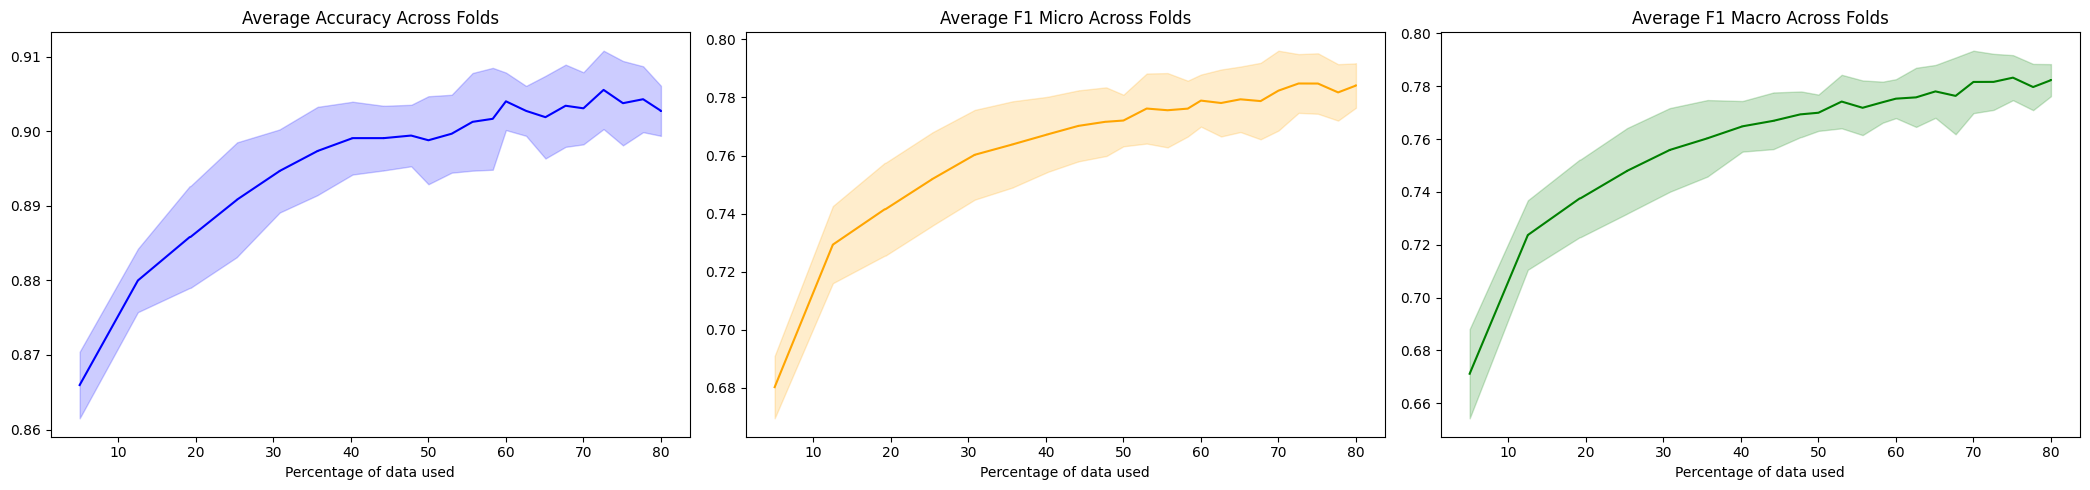

In [15]:
import matplotlib.pyplot as plt
import numpy as np

common_data_points = sorted(list(set(point for fold_points in all_fold_data_used for point in fold_points)))

# Interpolate metrics for each fold to the common data points
avg_accuracies = []
avg_f1_micros = []
avg_f1_macros = []
std_accuracies = []
std_f1_micros = []
std_f1_macros = []

for point in common_data_points:
    point_accuracies = []
    point_f1_micros = []
    point_f1_macros = []
    for i in range(N_SPLITS):
        # np.interp requires x-coordinates to be increasing
        sorted_indices = np.argsort(all_fold_data_used[i])
        sorted_data = np.array(all_fold_data_used[i])[sorted_indices]
        
        sorted_acc = np.array(all_fold_accuracies[i])[sorted_indices]
        sorted_f1m = np.array(all_fold_f1_micros[i])[sorted_indices]
        sorted_f1ma = np.array(all_fold_f1_macros[i])[sorted_indices]
        
        # Use interpolation to estimate the metric value at the common 'point'
        point_accuracies.append(np.interp(point, sorted_data, sorted_acc))
        point_f1_micros.append(np.interp(point, sorted_data, sorted_f1m))
        point_f1_macros.append(np.interp(point, sorted_data, sorted_f1ma))
    
    avg_accuracies.append(np.mean(point_accuracies))
    avg_f1_micros.append(np.mean(point_f1_micros))
    avg_f1_macros.append(np.mean(point_f1_macros))
    
    std_accuracies.append(np.std(point_accuracies))
    std_f1_micros.append(np.std(point_f1_micros))
    std_f1_macros.append(np.std(point_f1_macros))

# Convert to numpy arrays for easier plotting
avg_accuracies = np.array(avg_accuracies)
avg_f1_micros = np.array(avg_f1_micros)
avg_f1_macros = np.array(avg_f1_macros)
std_accuracies = np.array(std_accuracies)
std_f1_micros = np.array(std_f1_micros)
std_f1_macros = np.array(std_f1_macros)

# --- Plotting the Averaged Learning Curve ---
fig, axs = plt.subplots(1, 3, figsize=(21, 5))
data_used_percent = [round(data / len(X) * 100, 1) for data in common_data_points]

# Plot for Accuracy
axs[0].plot(data_used_percent, avg_accuracies, label="Avg Accuracy", color="blue")
axs[0].fill_between(data_used_percent, avg_accuracies - std_accuracies, avg_accuracies + std_accuracies, color='blue', alpha=0.2)
axs[0].set_xlabel("Percentage of data used")
axs[0].set_title("Average Accuracy Across Folds")

# Plot for F1 Micro
axs[1].plot(data_used_percent, avg_f1_micros, label="Avg F1 Micro", color="orange")
axs[1].fill_between(data_used_percent, avg_f1_micros - std_f1_micros, avg_f1_micros + std_f1_micros, color='orange', alpha=0.2)
axs[1].set_xlabel("Percentage of data used")
axs[1].set_title("Average F1 Micro Across Folds")

# Plot for F1 Macro
axs[2].plot(data_used_percent, avg_f1_macros, label="Avg F1 Macro", color="green")
axs[2].fill_between(data_used_percent, avg_f1_macros - std_f1_macros, avg_f1_macros + std_f1_macros, color='green', alpha=0.2)
axs[2].set_xlabel("Percentage of data used")
axs[2].set_title("Average F1 Macro Across Folds")

# Adjust layout and show the plots
plt.tight_layout()
plt.show()

for i in range(N_SPLITS):
    result = pd.DataFrame({
        'Data Used': all_fold_data_used[i],
        'Accuracy': all_fold_accuracies[i],
        'F1 Micro': all_fold_f1_micros[i],
        'F1 Macro': all_fold_f1_macros[i],
    })

    result.to_csv(f'results/{filename}-{i+1}-results.csv', index=False)